In [ ]:
!pip install yfinance
!pip install matplotlib
!pip install pandas_market_calendars
!pip install nelson-siegel-svensson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 9.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os
import sys

# Mount Google Drive
drive.mount('/content/drive')

# List directories in the mounted drive
drive_path = '/content/drive/MyDrive/MH4518'
directories = os.listdir(drive_path)

# Print the list of directories
print("Directories in MyDrive/MH4518:")
for directory in directories:
    print(directory)

sys.path.append('/content/drive/MyDrive/MH4518')



Mounted at /content/drive
Directories in MyDrive/MH4518:
deep_neural_network.py
data
docs
CalibrationNeuralNetwork.ipynb
DataGeneration.ipynb
model
__pycache__
Heston.py
MH4518 Group Project.gdoc
mh4518.ipynb


# Import Libraries


In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
from decimal import Decimal, getcontext
import math
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, GoodFriday, EasterMonday
from pandas.tseries.offsets import CustomBusinessDay
import pandas_market_calendars as mcal
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
import pandas_market_calendars as mcal
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from scipy.optimize import minimize

import importlib
import Heston  # Import the module (not just the class)

importlib.reload(Heston)  # Reload the module
from Heston import Heston

# **Define Euro Holiday Class**


In [ ]:
class ECBHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Year\'s Day', month=1, day=1),
        GoodFriday,
        EasterMonday,
        Holiday('Labour Day', month=5, day=1),
        Holiday('Christmas Day', month=12, day=25),
        Holiday('Boxing Day', month=12, day=26),
        Holiday('New Year\'s Eve', month=12, day=31),
    ]

# Create a custom business day offset with the ECB holiday calendar
ecb = CustomBusinessDay(calendar=ECBHolidayCalendar())

# **Functions to use**

In [ ]:
def get_ecb_business_days_ago(dynamic_date, days):
    dynamic_date = pd.Timestamp(dynamic_date)
    return dynamic_date - days * ecb

In [ ]:
def business_days_between(start_date, end_date):
    """
    Calculate the number of business days between two dates using the ECB holiday calendar.

    Parameters:
    - start_date (str or pd.Timestamp): The start date in 'YYYY-MM-DD' format or as a Timestamp.
    - end_date (str or pd.Timestamp): The end date in 'YYYY-MM-DD' format or as a Timestamp.

    Returns:
    - int: Number of business days between the two dates, considering ECB holidays.
    """
    # Convert input to pandas Timestamp if it's a string
    if isinstance(start_date, str):
        start_date = pd.Timestamp(start_date)
    if isinstance(end_date, str):
        end_date = pd.Timestamp(end_date)

    # Generate a range of business days using the ECB holiday calendar
    business_days = pd.date_range(start=start_date, end=end_date, freq=ecb)

    # Return the number of business days
    return len(business_days)

In [ ]:
def SimGBMexact(Nsim, S0, v, sigma, Deltat, T):
  m=T/Deltat
  m = int(m)
  # Assuming S0, Nsim, and m are defined
  S = np.full((Nsim, m+1), S0)

  for i in range(Nsim):
    Z = np.random.normal(0,1,m)
    for j in range(1, m+1):
      S[i, j] = S[i, j-1] * np.exp((v * Deltat) + (sigma * np.sqrt(Deltat) * Z[j-1]))
  return S

In [ ]:
def payoff(no_of_certs, spath, issue_price=1000,s0=3487.05, barrier=1743.525):
  smin = min(spath)
  # smin = 900
  sfinal = spath[-1]
  # sfinal = 5000
  # above initial level and barrier not breached
  if sfinal>=s0 and smin>=barrier:
    return ((sfinal/s0)-1)*1.5*(issue_price*no_of_certs) + (issue_price*no_of_certs)
  elif sfinal>=s0 and smin<barrier:
    return (sfinal/s0)*(issue_price*no_of_certs)
  elif sfinal<s0 and smin<barrier:
    return (sfinal/s0)*(issue_price*no_of_certs)
  else:
    return issue_price*no_of_certs

In [ ]:
def visualize_simulation(SimGBMEx):
    plt.figure(figsize=(10, 6))

    for i in range(SimGBMEx.shape[0]):  # Loop over each simulation
        plt.plot(SimGBMEx[i, :], linewidth=1)

    plt.title('Geometric Brownian Motion Simulation', fontsize=16)
    plt.xlabel('Time Steps', fontsize=14)
    plt.ylabel('Simulated Asset Price', fontsize=14)

    # Show the plot
    plt.grid(True)
    plt.show()

In [ ]:
def SimGBMexactAV(Nsim, S0, v, sigma, Deltat, T, collate=False):
  m=T/Deltat
  m = int(m)
  # Assuming S0, Nsim, and m are defined
  S = np.full((Nsim, m+1), S0)
  Stilde = np.full((Nsim, m+1), S0)

  for i in range(Nsim):
    Z = np.random.normal(0,1,m)
    for j in range(1, m+1):
      S[i, j] = S[i, j-1] * np.exp((v * Deltat) + (sigma * np.sqrt(Deltat) * Z[j-1]))
      Stilde[i, j] = Stilde[i, j-1] * np.exp((v * Deltat) + (sigma * np.sqrt(Deltat) * -Z[j-1]))

  if collate:
    out = np.zeros((2 * Nsim, m + 1))
    for i in range(Nsim):
      out[2 * i, :] = S[i, :]        # Fill odd rows (0-based index for Python)
      out[2 * i + 1, :] = Stilde[i, :]  # Fill even rows
      return out
  else:
    return np.vstack((S, Stilde))  # Concatenate S and Stilde vertically


In [ ]:
def SimGBMexactperturbed(Nsim, S0, v, sigma, Deltat, T,h):
  m=T/Deltat
  m = int(m)
  # Assuming S0, Nsim, and m are defined
  S = np.full((Nsim, m+1), S0)
  S_plush = np.full((Nsim, m+1), S0+h)
  S_minush = np.full((Nsim, m+1), S0-h)
  for i in range(Nsim):
    Z = np.random.normal(0,1,m)
    for j in range(1, m+1):
      # print(np.exp((v * Deltat) + (sigma * np.sqrt(Deltat) * Z[j-1])))
      S[i, j] = S[i, j-1] * np.exp((v * Deltat) + (sigma * np.sqrt(Deltat) * Z[j-1]))
      S_plush[i, j] = S_plush[i, j-1] * np.exp((v * Deltat) + (sigma * np.sqrt(Deltat) * Z[j-1]))
      S_minush[i, j] = S_minush[i, j-1] * np.exp((v * Deltat) + (sigma * np.sqrt(Deltat) * Z[j-1]))
  return S, S_plush, S_minush

# **Euro short-term rate**


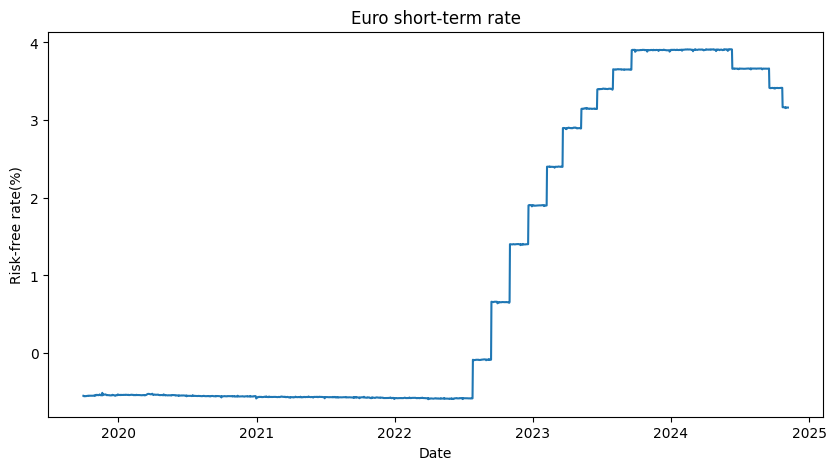

In [ ]:
ecbdata = pd.read_csv('ECB Data.csv')
ecbdata['Close']=ecbdata['Euro short-term rate - Volume-weighted trimmed mean rate (EST.B.EU000A2X2A25.WT)']
ecbdata['DATE'] = pd.to_datetime(ecbdata['DATE']).dt.date
ecbdata = ecbdata[['DATE','Close']]

plt.figure(figsize=(10, 5))
plt.plot(ecbdata['DATE'], ecbdata['Close'], label='Risk-free rate(%)')
plt.title('Euro short-term rate')
plt.xlabel('Date')
plt.ylabel('Risk-free rate(%)')

input_date = "2024-11-06"
input_date = pd.to_datetime(input_date).date()
r = ecbdata.loc[ecbdata['DATE'] == input_date,'Close'].iloc[0]/100

### Underlying Asset - 1 Year prior to Today


In [ ]:
underlying_ticker = yf.Ticker("^STOXX50E")
underlying_asset_backtest = underlying_ticker.history(period="1y", start = "2024-07-31", end = "2024-11-01")
underlying_asset_backtestlist = underlying_asset_backtest['Close'].tolist()

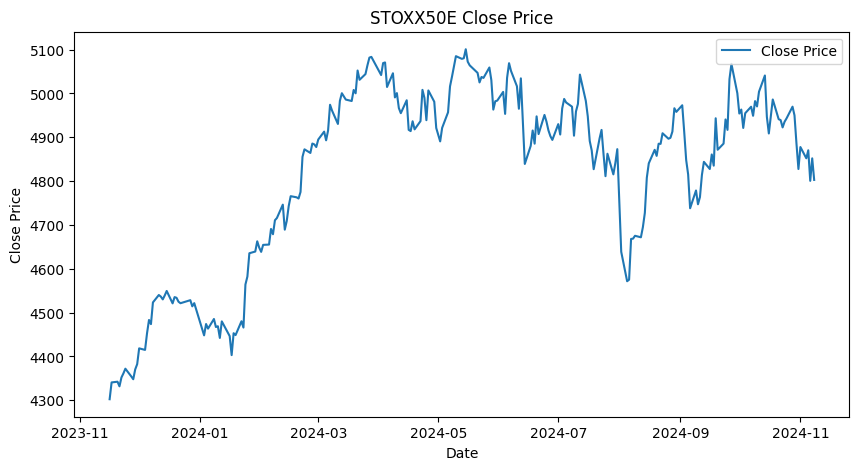

In [ ]:
underlying_ticker = yf.Ticker("^STOXX50E")
start_date = get_ecb_business_days_ago(date.today(), 251)
end_date = date.today()

underlying_asset_fixed_window = underlying_ticker.history(period="1y", start = start_date, end = end_date)
plt.figure(figsize=(10, 5))
plt.plot(underlying_asset_fixed_window.index, underlying_asset_fixed_window['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('STOXX50E Close Price')
plt.legend()
plt.show()

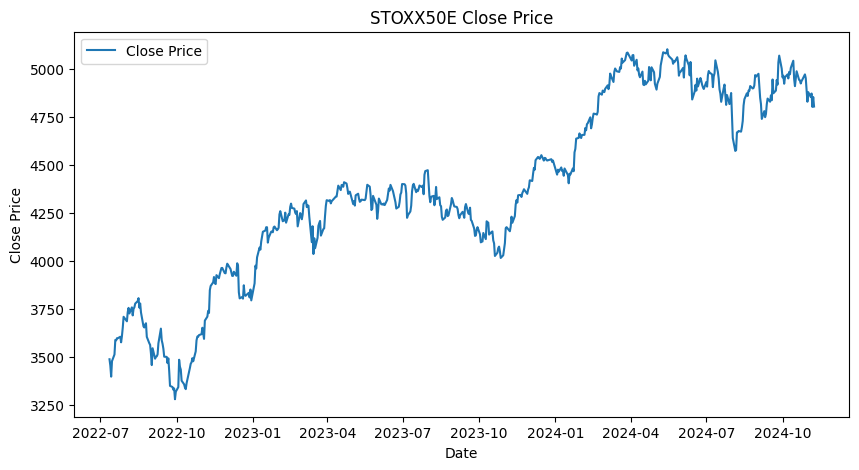

In [ ]:
underlying_ticker = yf.Ticker("^STOXX50E")
start_date = '2022-07-12'
end_date = date.today()

underlying_asset_full_duration = underlying_ticker.history(period="1y", start = start_date, end = end_date)
plt.figure(figsize=(10, 5))
plt.plot(underlying_asset_full_duration.index, underlying_asset_full_duration['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('STOXX50E Close Price')
plt.legend()
plt.show()

### Product Chart

In [ ]:
price_list = [1000] #on 15 Aug (initial fixing date)
price_list.append(1004.94)
price_list.append(1014.34)
price_list.append(1038.38)
price_list.append(1035.84)
price_list.append(1038.86)
price_list.append(1043.04)
price_list.append(1040.05)
price_list.append(1035.32)
price_list.append(1043.37)
price_list.append(1051.12)
price_list.append(1070.67)
price_list.append(1065.75)
price_list.append(1081.87)
price_list.append(1085.35)
price_list.append(1079.65)
price_list.append(1088.13)
price_list.append(1074.78)
price_list.append(1083.98)
price_list.append(1084.1)
price_list.append(1094.81)
price_list.append(1096.59)
price_list.append(1100.79)
price_list.append(1087.12)
price_list.append(1090.5)
price_list.append(1074.59)
price_list.append(1051.98)
price_list.append(1048.99)
price_list.append(1050.54)
price_list.append(1058.35)
price_list.append(1033.18)
price_list.append(1024.79)
price_list.append(1021.66)
price_list.append(1010.7)
price_list.append(986.78)
price_list.append(1011.15)
price_list.append(994.49)
price_list.append(996.3)
price_list.append(996.59)
price_list.append(997.4)
price_list.append(1009.77)
price_list.append(1026.67)
price_list.append(1000.74)
price_list.append(988.93)
price_list.append(992.67)
price_list.append(976.8)
price_list.append(984.62)
price_list.append(968.13)
price_list.append(943.5)
price_list.append(946.92)
price_list.append(946.46)
price_list.append(928.95)
price_list.append(922.17)
price_list.append(933.1)
price_list.append(938.07)
price_list.append(948.47)
price_list.append(935.11)
price_list.append(913.56)
price_list.append(906.36)
price_list.append(908.8)
price_list.append(900.64)
price_list.append(902.51)
price_list.append(900.61)
price_list.append(914.19)
price_list.append(928.24)
price_list.append(938.55)
price_list.append(943.36)
price_list.append(951.71)
price_list.append(941.21)
price_list.append(955.8)
price_list.append(971.33)
price_list.append(978.07)
price_list.append(980.7)
price_list.append(978.84)
price_list.append(984.72)
price_list.append(995.65)
price_list.append(991.67)
price_list.append(979.68)
price_list.append(1005.96)
price_list.append(1015.05)
price_list.append(1024.29)
price_list.append(1023.39)
price_list.append(1054.78)
price_list.append(1066.28)
price_list.append(1070.48)
price_list.append(1080.4)
price_list.append(1069.34)
price_list.append(1068.15)
price_list.append(1081.6)
price_list.append(1080.77)
price_list.append(1088.11)
price_list.append(1092.15)
price_list.append(1095.72)
price_list.append(1093.38)
price_list.append(1088.37)
price_list.append(1085.66)
price_list.append(1091.56)
price_list.append(1094.99)
price_list.append(1091.83)
price_list.append(1090.79)
price_list.append(1082.65)
price_list.append(1085)
price_list.append(1078.25)
price_list.append(1082.35)
price_list.append(1077.26)
price_list.append(1097.15)
price_list.append(1094.06)
price_list.append(1050.75)
price_list.append(1046.75)
price_list.append(1043.59)
price_list.append(1042.15)
price_list.append(1063.45)
price_list.append(1045.19)
price_list.append(1044.45)
price_list.append(1049.7)
price_list.append(1040.56)
price_list.append(1052.61)
price_list.append(1036.25)
price_list.append(1065.3)
price_list.append(1089.01)
price_list.append(1085.65)
price_list.append(1100.57)
price_list.append(1120.99)
price_list.append(1117.89)
price_list.append(1128.62)
price_list.append(1140.82)
price_list.append(1147.08)
price_list.append(1154.42)
price_list.append(1157.03)
price_list.append(1159.57)
price_list.append(1141.35)
price_list.append(1145.81)
price_list.append(1159.92)
price_list.append(1161.02)
price_list.append(1158.81)
price_list.append(1172.11)
price_list.append(1171.9)
price_list.append(1173.61)
price_list.append(1174.69)
price_list.append(1173.17)
price_list.append(1199.93)
price_list.append(1205.34)
price_list.append(1191.96)
price_list.append(1193.74)
price_list.append(1196.24)
price_list.append(1209.49)
price_list.append(1192.6)
price_list.append(1207.87)
price_list.append(1211.59)
price_list.append(1219.87)
price_list.append(1225.06)
price_list.append(1217.66)
price_list.append(1214.85)
price_list.append(1210.13)
price_list.append(1203.62)
price_list.append(1209.16)
price_list.append(1187)
price_list.append(1205.7)
price_list.append(1207.25)
price_list.append(1194.34)
price_list.append(1203.61)
price_list.append(1221.03)
price_list.append(1227.28)
price_list.append(1214.45)
price_list.append(1220.14)
price_list.append(1212.04)
price_list.append(1190.07)
price_list.append(1154.19)
price_list.append(1145.12)
price_list.append(983.74)
price_list.append(968.19)
price_list.append(977.78)
price_list.append(1084.17)
price_list.append(1114.6)
price_list.append(1167.1)
price_list.append(1183.33)
price_list.append(1149.11)
price_list.append(1150.64)
price_list.append(1162.61)
price_list.append(1184.29)
price_list.append(1209.01)
price_list.append(1221.78)
price_list.append(1217.64)
price_list.append(1230.33)
price_list.append(1214.73)
price_list.append(1218.89)
price_list.append(1228.39)
price_list.append(1226.89)
price_list.append(1239.89)
price_list.append(1249.88)
price_list.append(1246.53)
price_list.append(1257.83)
price_list.append(1266.86)
price_list.append(1264.14)
price_list.append(1268.35)
price_list.append(1270.89)
price_list.append(1266.19)
price_list.append(1252.18)
price_list.append(1254.08)
price_list.append(1256.43)
price_list.append(1236.94)
price_list.append(1240.45)
price_list.append(1248.59)
price_list.append(1269.25)
price_list.append(1276.24)
price_list.append(1267.97)
price_list.append(1260.24)
price_list.append(1262.61)
price_list.append(1269.87)
price_list.append(1270.59)
price_list.append(1270.45)
price_list.append(1272.81)
price_list.append(1304.89)
price_list.append(1301.68)
price_list.append(1288.82)
price_list.append(1258.05)
price_list.append(1263.32)
price_list.append(1285.64)
price_list.append(1269.67)
price_list.append(1240.01)
price_list.append(1254.37)
price_list.append(1275.84)
price_list.append(1267.12)
price_list.append(1267.86)
price_list.append(1264.04)
price_list.append(1268.33)
price_list.append(1267.34)
price_list.append(1272.87)
price_list.append(1287.17)
price_list.append(1297.63)
price_list.append(1294.59)
price_list.append(1311.03)
price_list.append(1294.84)
price_list.append(1289.91)
price_list.append(1280.82)
price_list.append(1275.86)
price_list.append(1263.48)
price_list.append(1268.97)
price_list.append(1275.33)
price_list.append(1292.17)
price_list.append(1295.09)
price_list.append(1314.16)
price_list.append(1311.54)
price_list.append(1310.36)
price_list.append(1292.97)
price_list.append(1246.1)
price_list.append(1253.97)
price_list.append(1262.41)
price_list.append(1273.79)
price_list.append(1301.94)
price_list.append(1314.47)
price_list.append(1314.92)
price_list.append(1300.6)
price_list.append(1305.23)
price_list.append(1303.14)
price_list.append(1305.59)
price_list.append(1313.5)
price_list.append(1312.49)
price_list.append(1312.02)
price_list.append(1296.1)
price_list.append(1331.97)
price_list.append(1344.21)
price_list.append(1346.13)
price_list.append(1293.46)
price_list.append(1280.17)
price_list.append(1294.65)
price_list.append(1295.69)
price_list.append(1277.25)
price_list.append(1291.46)
price_list.append(1313.87)
price_list.append(1291.53)
price_list.append(1291.47)
price_list.append(1278.78)
price_list.append(1278.05)
price_list.append(1258.68)
price_list.append(1253.11)
price_list.append(1257.1)
price_list.append(1270.49)
price_list.append(1270.87)
price_list.append(1259.08)
price_list.append(1257.93)
price_list.append(1283.32)
price_list.append(1293.46)
price_list.append(1289.11)
price_list.append(1286.73)
price_list.append(1279.9)
price_list.append(1275.84)
price_list.append(1274.86)
price_list.append(1261.77)
price_list.append(1255.41)
price_list.append(1261.99)
price_list.append(1267.37)
price_list.append(1266.31)
price_list.append(1260.33)
price_list.append(1281.49)
price_list.append(1282.99)
price_list.append(1265.36)
price_list.append(1263.78)
price_list.append(1281.08)
price_list.append(1257.57)
price_list.append(1251.14)
price_list.append(1234.15)
price_list.append(1224.42)
price_list.append(1225.21)
price_list.append(1234.45)
price_list.append(1240.44)
price_list.append(1223.97)
price_list.append(1208.89)
price_list.append(1210.67)
price_list.append(1209.78)
price_list.append(1222.85)
price_list.append(1212.97)
price_list.append(1248.69)
price_list.append(1249.71)
price_list.append(1245.73)
price_list.append(1223.26)
price_list.append(1228.25)
price_list.append(1227.94)
price_list.append(1211.44)
price_list.append(1206.15)
price_list.append(1185.68)
price_list.append(1189.67)
price_list.append(1199.37)
price_list.append(1200.8)
price_list.append(1191.55)
price_list.append(1179.84)
price_list.append(1183.85)
price_list.append(1192.06)
price_list.append(1203.77)
price_list.append(1229.13)
price_list.append(1232.78)
price_list.append(1225.93)
price_list.append(1224.44)
price_list.append(1232.53)
price_list.append(1251.19)
price_list.append(1239.05)
price_list.append(1248.45)
price_list.append(1275.56)
price_list.append(1283.94)
price_list.append(1282.46)
price_list.append(1294.92)
price_list.append(1297.76)
price_list.append(1292.96)
price_list.append(1301.07)
price_list.append(1304.41)
price_list.append(1307.98)
price_list.append(1302.3)
price_list.append(1297.59)
price_list.append(1310.19)
price_list.append(1313.35)
price_list.append(1325.24)
price_list.append(1322.4)
price_list.append(1340.36)
price_list.append(1352.03)
price_list.append(1348.71)
price_list.append(1366.42)
price_list.append(1373.18)
price_list.append(1373.08)
price_list.append(1369.46)
price_list.append(1374.07)
price_list.append(1380.79)
price_list.append(1367.51)
price_list.append(1373.66)
price_list.append(1373.34)
price_list.append(1367.65)
price_list.append(1368.5)
price_list.append(1370.25)
price_list.append(1365.51)
price_list.append(1365.35)
price_list.append(1337.93)
price_list.append(1343.65)
price_list.append(1343.87)
price_list.append(1351.45)
price_list.append(1345.53)
price_list.append(1345.39)
price_list.append(1334.73)
price_list.append(1345.77)
price_list.append(1339.16)
price_list.append(1333.76)
price_list.append(1318.97)
price_list.append(1336.81)
price_list.append(1335.23)
price_list.append(1349.61)
price_list.append(1343.93)
price_list.append(1384.16)
price_list.append(1390.4)
price_list.append(1409.97)
price_list.append(1412.12)
price_list.append(1422.02)
price_list.append(1416.64)
price_list.append(1414.49)
price_list.append(1420.74)
price_list.append(1420.46)
price_list.append(1432.96)
price_list.append(1430.67)
price_list.append(1446.26)
price_list.append(1446.12)
price_list.append(1459.12)
price_list.append(1435.4)
price_list.append(1443.1)
price_list.append(1466.03)
price_list.append(1474.2)
price_list.append(1473.99)
price_list.append(1471.67)
price_list.append(1478.2)
price_list.append(1509.81)
price_list.append(1518.38)
price_list.append(1515.36)
price_list.append(1523.82)
price_list.append(1524.12)
price_list.append(1520.47)
price_list.append(1528.09)
price_list.append(1535.51)
price_list.append(1527.15)
price_list.append(1540.52)
price_list.append(1564.14)
price_list.append(1557.45)
price_list.append(1548.28)
price_list.append(1566.06)
price_list.append(1578.51)
price_list.append(1571.87)
price_list.append(1571.53)
price_list.append(1569.3)
price_list.append(1582.53)
price_list.append(1578.87)
price_list.append(1598.11)
price_list.append(1594.64)
price_list.append(1598.09)
price_list.append(1605.99)
price_list.append(1612.71)
price_list.append(1615.85)
price_list.append(1595.27)
price_list.append(1608.23)
price_list.append(1610.49)
price_list.append(1588.93)
price_list.append(1600.43)
price_list.append(1579.39)
price_list.append(1580.31)
price_list.append(1572.63)
price_list.append(1564.74)
price_list.append(1579.3)
price_list.append(1550.87)
price_list.append(1551.91)
price_list.append(1555.73)
price_list.append(1550.93)
price_list.append(1563.27)
price_list.append(1589.53)
price_list.append(1581.8)
price_list.append(1564.28)
price_list.append(1596.74)
price_list.append(1586.85)
price_list.append(1565.88)
price_list.append(1554.35)
price_list.append(1566.4)
price_list.append(1580.56)
price_list.append(1605.71)
price_list.append(1614.29)
price_list.append(1635.95)
price_list.append(1637.19)
price_list.append(1638.39)
price_list.append(1648.03)
price_list.append(1637.36)
price_list.append(1634.63)
price_list.append(1631.55)
price_list.append(1621.28)
price_list.append(1626.98)
price_list.append(1625.45)
price_list.append(1637.61)
price_list.append(1626.23)
price_list.append(1601.51)
price_list.append(1609)
price_list.append(1607.11)
price_list.append(1615.72)
price_list.append(1593.36)
price_list.append(1629.25)
price_list.append(1641.23)
price_list.append(1635.22)
price_list.append(1619.83)
price_list.append(1594.56)
price_list.append(1586.71)
price_list.append(1549.53)
price_list.append(1564.3)
price_list.append(1583.76)
price_list.append(1567.05)
price_list.append(1591.9)
price_list.append(1579.21)
price_list.append(1593.15)
price_list.append(1589.43)
price_list.append(1583.21)
price_list.append(1575.57)
price_list.append(1573.45)
price_list.append(1583.43)
price_list.append(1571.94)
price_list.append(1598.76)
price_list.append(1610.08)
price_list.append(1604.26)
price_list.append(1601.53)
price_list.append(1575.75)
price_list.append(1596.63)
price_list.append(1600.73)
price_list.append(1628.09)
price_list.append(1606.88)
price_list.append(1591.59)
price_list.append(1566.91)
price_list.append(1558.83)
price_list.append(1546.18)
price_list.append(1571.65)
price_list.append(1570.86)
price_list.append(1551.64)
price_list.append(1537.05)
price_list.append(1557.68)
price_list.append(1540.61)
price_list.append(1546.45)
price_list.append(1558.07)
price_list.append(1548.08)
price_list.append(1467.65)
price_list.append(1433.09)
price_list.append(1434.38)
price_list.append(1464.74)
price_list.append(1471.2)
price_list.append(1472.2)
price_list.append(1476.24)
price_list.append(1479.7)
price_list.append(1496.07)
price_list.append(1534.2)
price_list.append(1539.96)
price_list.append(1552.83)
price_list.append(1548.52)
price_list.append(1559.36)
price_list.append(1557.61)
price_list.append(1566.48)
price_list.append(1563.98)
price_list.append(1566.2)
price_list.append(1573.19)
price_list.append(1598.05)
price_list.append(1587.84)
price_list.append(1597.1)
price_list.append(1570.44)
price_list.append(1543.11)
price_list.append(1528.49)
price_list.append(1497.52)
price_list.append(1519.02)
price_list.append(1495.66)
price_list.append(1514.65)
price_list.append(1527.61)
price_list.append(1542.5)
price_list.append(1535.31)
price_list.append(1544.71)
price_list.append(1532.49)
price_list.append(1577.14)
price_list.append(1549.14)
price_list.append(1555.48)
price_list.append(1579.11)
price_list.append(1568.72)
price_list.append(1619.58)
price_list.append(1630.77)
price_list.append(1606.5)
price_list.append(1584.84)
price_list.append(1592.36)
price_list.append(1574.5)
price_list.append(1593.79)
price_list.append(1590.37)
price_list.append(1587.97)
price_list.append(1598.62)
price_list.append(1592.9) # 10 Oct 2024

# **Real World: Simulate GBM for Today's Price**

In [ ]:
#Obtain parameters for simulation

np.random.seed(4518)
trading_days = business_days_between(date.today(), date(2025, 7, 14))
Nsim = 10000
T = trading_days/252
dt = 1/252

es50_prices = underlying_asset_fixed_window['Close']
# Set precision (for example, 10 decimal places)
getcontext().prec = 10

# Convert prices to Decimal for high precision
es50_prices_decimal = [Decimal(price) for price in es50_prices]

# Calculate log prices using Decimal
es50_logprices = [Decimal(math.log(price)) for price in es50_prices_decimal]

# Convert to a NumPy array for easy indexing and calculations
es50_logprices = np.array(es50_logprices, dtype=object)  # Use dtype=object to hold Decimal

# Length of prices
n0 = len(es50_prices)

# Calculate log returns
es50_logreturns = es50_logprices[1:n0] - es50_logprices[0:n0 - 1]

# Optionally, convert HSIlogreturns to a more usable format
# Here, we convert back to floats if needed for further calculations
es50_logreturns_float = np.array([float(r) for r in es50_logreturns])

v = np.mean(es50_logreturns_float) / dt
sigma = np.std(es50_logreturns_float) / np.sqrt(dt)
print(v)
print(sigma)

0.11268910450060098
0.13435042152611715


<ipython-input-20-2f99ba40b283>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


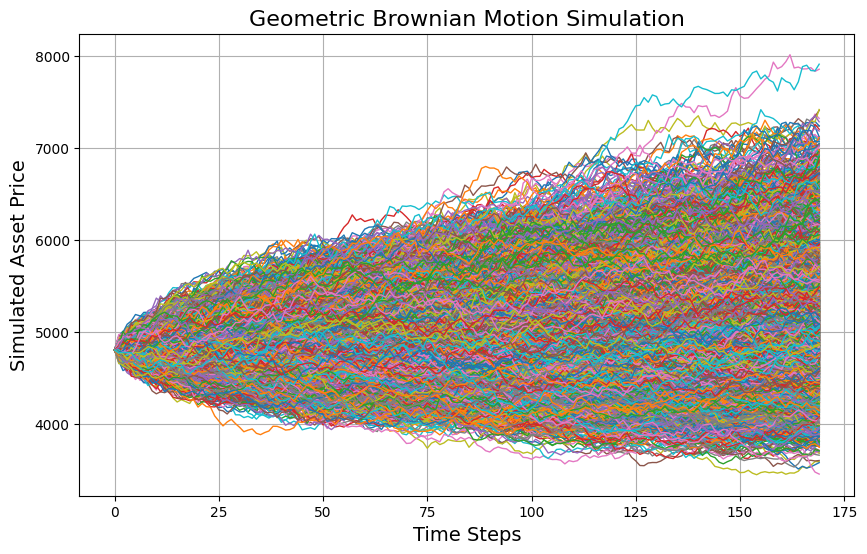

In [ ]:
#Simulation based on real-world condition for today's price
simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)
visualize_simulation(simulation_exact)

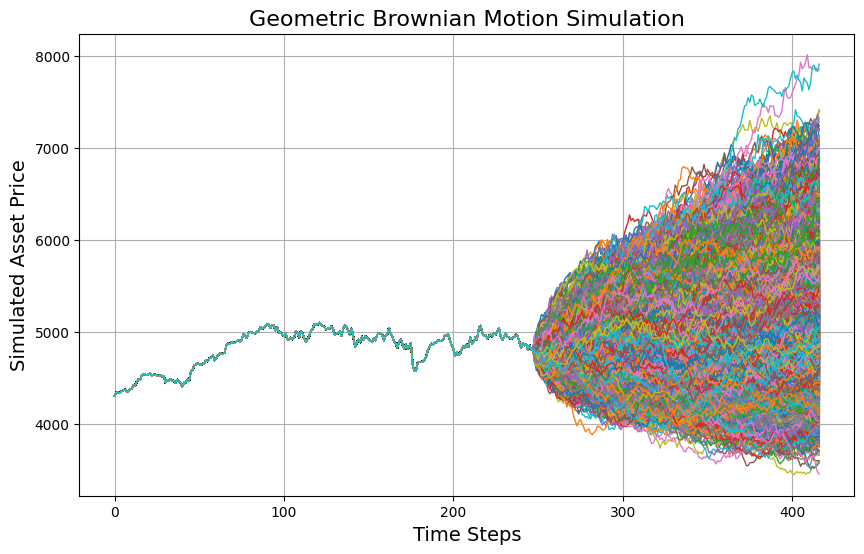

In [ ]:
# Prepend the values to each inner array using np.concatenate
updated_array = np.array([np.concatenate((es50_prices, inner)) for inner in simulation_exact])
visualize_simulation(updated_array)

In [ ]:
#Collate payoffs of N simulated paths
payoff_exact = []
for i in range(0,Nsim):
  payoff_exact.append(payoff(1,updated_array[i]))
Tminust= (business_days_between(date.today(),"2025-07-14"))/252
discount_factor = math.exp(-r*Tminust)
payoff_exact_discounted = [payoff_exact[i]*discount_factor for i in range(len(payoff_exact))]
PV_Payoff = sum(payoff_exact_discounted)/len(payoff_exact_discounted)
print(PV_Payoff)
print(np.sqrt(np.var(payoff_exact_discounted)))

1703.6450738669314
241.62620242832529


# **Risk-Neutral World: Simulate GBM for Today's Price**

In [ ]:
np.random.seed(4518)
trading_days = business_days_between(date.today(), date(2025, 7, 14))
Nsim = 10000
T = trading_days/252
dt = 1/252
specific_date=date.today()
es50_prices = underlying_asset_fixed_window['Close']
# Set precision (for example, 10 decimal places)
getcontext().prec = 10

# Convert prices to Decimal for high precision
es50_prices_decimal = [Decimal(price) for price in es50_prices]

# Calculate log prices using Decimal
es50_logprices = [Decimal(math.log(price)) for price in es50_prices_decimal]

# Convert to a NumPy array for easy indexing and calculations
es50_logprices = np.array(es50_logprices, dtype=object)  # Use dtype=object to hold Decimal

# Length of prices
n0 = len(es50_prices)

# Calculate log returns
es50_logreturns = es50_logprices[1:n0] - es50_logprices[0:n0 - 1]

# Optionally, convert HSIlogreturns to a more usable format
# Here, we convert back to floats if needed for further calculations
es50_logreturns_float = np.array([float(r) for r in es50_logreturns])

sigma_rnw = np.std(es50_logreturns_float) / np.sqrt(dt)
v_rnw= r - sigma**2/2
print(v_rnw)
print(sigma_rnw)


0.022594982117877322
0.13435042152611715


<ipython-input-24-99db2c66d446>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact_rnw = SimGBMexact(Nsim, es50_prices[n0-1],v_rnw,sigma_rnw,dt,T)


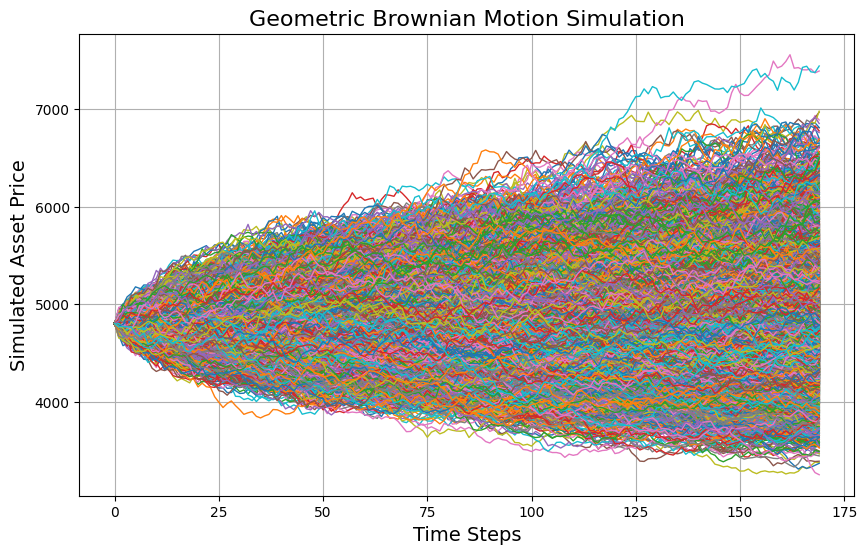

In [ ]:
#Simulation based on risk neutral world condition for today's price
simulation_exact_rnw = SimGBMexact(Nsim, es50_prices[n0-1],v_rnw,sigma_rnw,dt,T)
visualize_simulation(simulation_exact_rnw)


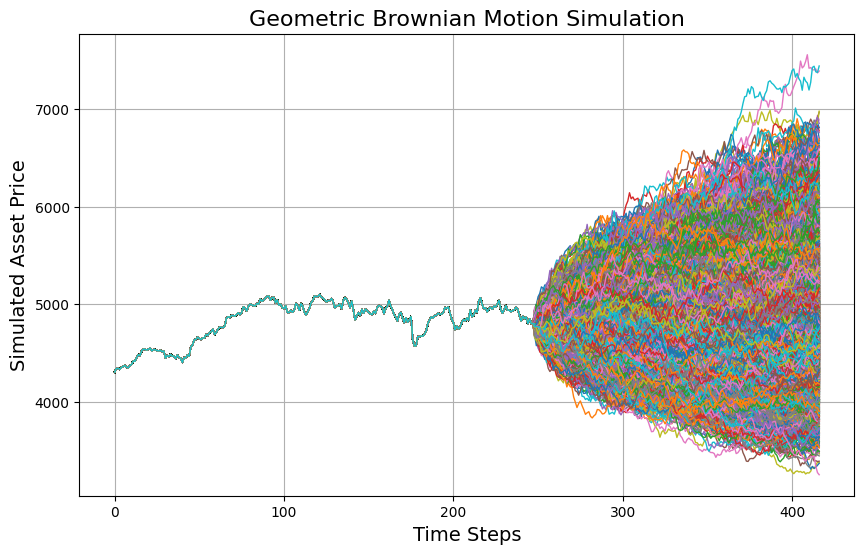

In [ ]:
# Prepend the values to each inner array using np.concatenate
updated_array_rnw = np.array([np.concatenate((es50_prices, inner)) for inner in simulation_exact_rnw])
visualize_simulation(updated_array_rnw)

In [ ]:
#Collate payoffs of N simulated paths
payoff_exact_rnw = []
for i in range(0,Nsim):
  payoff_exact_rnw.append(payoff(1,updated_array_rnw[i]))

payoff_exact_rnw_discounted = [payoff_exact_rnw[i]*discount_factor for i in range(len(payoff_exact_rnw))]
PV_Payoff_rnw = sum(payoff_exact_rnw_discounted)/len(payoff_exact_rnw_discounted)
print(PV_Payoff_rnw)
print(np.sqrt(np.var(payoff_exact_rnw_discounted)))

1575.0839125149678
227.38803304617377


# **Real World: Simulate GBM (Antithetic Variables) for Today's Price**

<ipython-input-27-934f5095b327>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_vr = SimGBMexactAV(int(Nsim/2),underlying_asset_fixed_window['Close'][-1],v,sigma,dt,T)


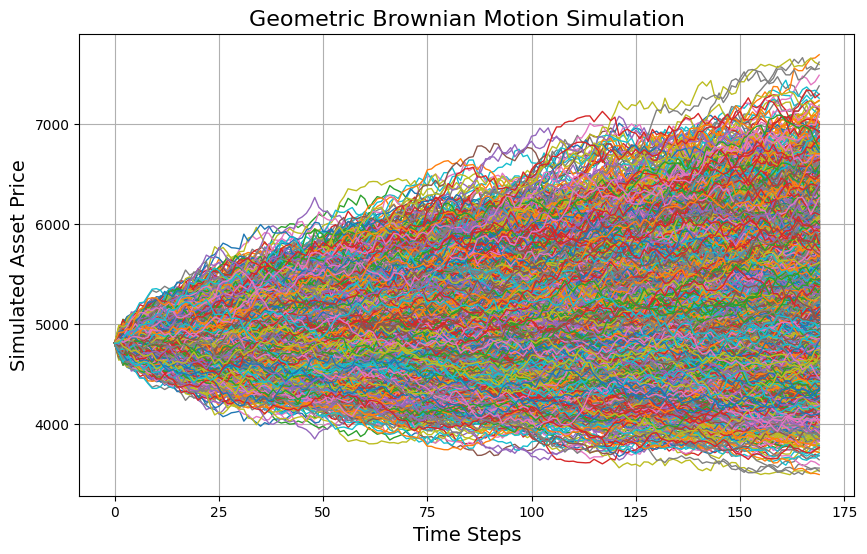

In [ ]:
np.random.seed(4423)
simulation_vr = SimGBMexactAV(int(Nsim/2),underlying_asset_fixed_window['Close'][-1],v,sigma,dt,T)
visualize_simulation(simulation_vr)

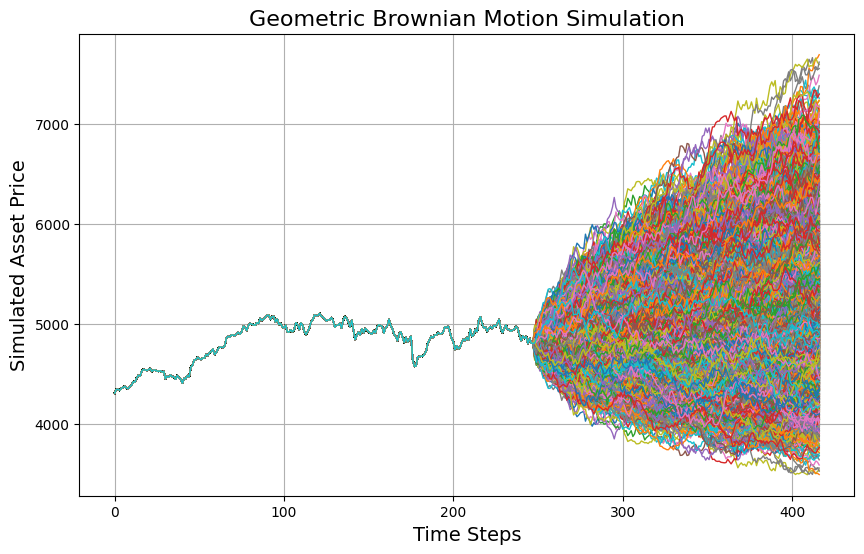

In [ ]:
# Prepend the values to each inner array using np.concatenate
updated_array_vr = np.array([np.concatenate((es50_prices, inner)) for inner in simulation_vr])
visualize_simulation(updated_array_vr)

In [ ]:
#Collate payoffs of N simulated paths
payoff_vr = []
for i in range(0,Nsim):
  payoff_vr.append(payoff(1,updated_array_vr[i]))
payoff_vr_discounted = [payoff_vr[i]*discount_factor for i in range(len(payoff_vr))]
PV_Payoff_vr = sum(payoff_vr_discounted)/len(payoff_vr_discounted)
print(PV_Payoff_vr)
print(np.sqrt(np.var(payoff_vr_discounted)))

1705.0561980437512
241.44176976044378


# **Risk-Neutral World: Simulate GBM (Antithetic Variables) for Today's Price**

<ipython-input-31-4ed36f3de443>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_vr_rnw = SimGBMexactAV(Nsim, es50_prices[n0-1],v_rnw,sigma_rnw,dt,T)


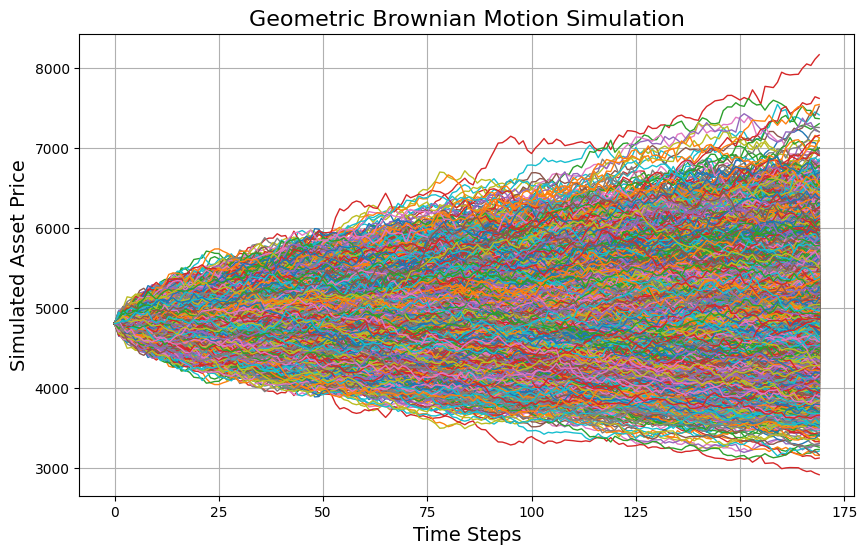

In [ ]:
#Simulation based on risk neutral world condition for today's price
simulation_vr_rnw = SimGBMexactAV(Nsim, es50_prices[n0-1],v_rnw,sigma_rnw,dt,T)
visualize_simulation(simulation_vr_rnw)

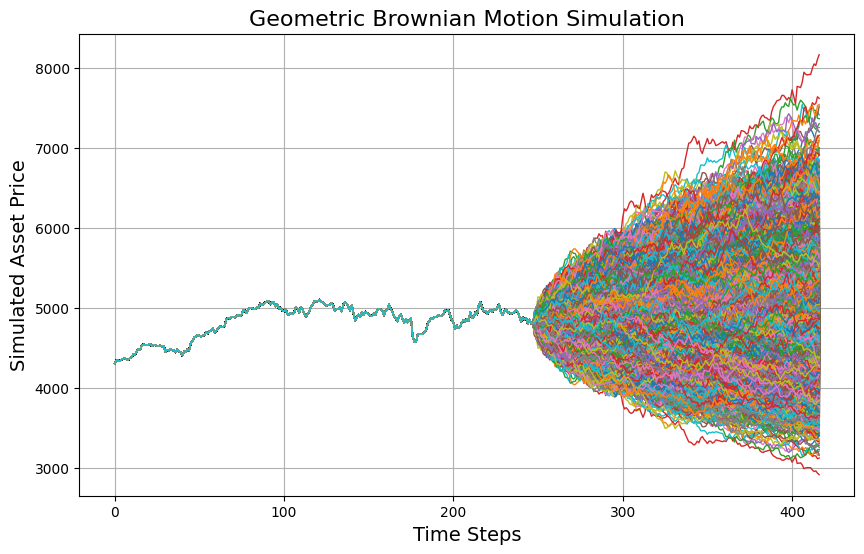

In [ ]:
# Prepend the values to each inner array using np.concatenate
updated_array_vr_rnw = np.array([np.concatenate((es50_prices, inner)) for inner in simulation_vr_rnw])
visualize_simulation(updated_array_vr_rnw)

In [ ]:
#Collate payoffs of N simulated paths
payoff_vr_rnw = []
for i in range(0,Nsim):
  payoff_vr_rnw.append(payoff(1,updated_array_vr_rnw[i]))

payoff_vr_rnw_discounted = [payoff_vr_rnw[i]*discount_factor for i in range(len(payoff_vr_rnw))]
PV_Payoff_vr_rnw = sum(payoff_vr_rnw_discounted)/len(payoff_vr_rnw_discounted)
print(PV_Payoff_vr_rnw)
print(np.sqrt(np.var(payoff_vr_rnw_discounted)))

1578.327579384963
231.4565167601961


# **Risk-Neutral World: Simulate Heston Model for Today's Price (5 Nov 2024)**

###Best Parameter from Calculation.ipynb

In [ ]:
opt_params_diffevol_dnn = [ 0.00203402,  0.29570897, -0.49303192,  0.00501894,  0.04218995]


In [ ]:
price_history_m = underlying_ticker.history(period="1y", start = '2022-07-12', end = '2024-11-05')
price_history_m = price_history_m['Close']

price_history_1y = underlying_ticker.history(period="1y", start = '2023-11-05', end = '2024-11-05')
price_history_1y = price_history_1y['Close'].values

price_history_9m = underlying_ticker.history(period="1y", start = '2024-01-01', end = '2024-11-05')
price_history_9m = price_history_9m['Close'].values

In [ ]:
# ECB rates
raw_ecb = pd.read_csv('/content/drive/MyDrive/MH4518/data/rate_yield_data.csv')

clean_ecb = raw_ecb[['DATA_TYPE_FM', 'TIME_PERIOD', 'OBS_VALUE']]
clean_ecb['TIME_PERIOD'] = pd.to_datetime(clean_ecb['TIME_PERIOD']).dt.tz_localize('Europe/Zurich')
clean_ecb = clean_ecb[clean_ecb['DATA_TYPE_FM'].str.startswith('BETA') | clean_ecb['DATA_TYPE_FM'].str.startswith('TAU')]

date_data = clean_ecb[clean_ecb['TIME_PERIOD'] == '2024-11-05']
# Extract parameters, handling potential missing data
interest_rate_values = []
parameter_names = ['BETA0', 'BETA1', 'BETA2', 'BETA3', 'TAU1', 'TAU2']
for param_name in parameter_names:
    value = date_data[date_data['DATA_TYPE_FM'] == param_name]['OBS_VALUE'].iloc[0]
    interest_rate_values.append(value)
curve = NelsonSiegelSvenssonCurve(beta0=interest_rate_values[0], beta1=interest_rate_values[1], beta2=interest_rate_values[2], beta3=interest_rate_values[3], tau1=interest_rate_values[4], tau2=interest_rate_values[5])
print(curve)

NelsonSiegelSvenssonCurve(beta0=1.0228541434, beta1=2.0754603015, beta2=-0.3654648858, beta3=5.2458264602, tau1=1.0175093618, tau2=11.5756849977)


<ipython-input-16-e9a396dca9be>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_ecb['TIME_PERIOD'] = pd.to_datetime(clean_ecb['TIME_PERIOD']).dt.tz_localize('Europe/Zurich')


In [ ]:
def get_lognormal_statistics(prices):
  log_data = np.log(prices)
  log_returns = log_data[1:] - log_data[:-1]
  mu = np.mean(log_returns)
  dev_2 = (log_returns-mu)**2
  mu = np.mean(dev_2)
  return mu

In [ ]:
mu  = get_lognormal_statistics(price_history_1y)

nb_business = business_days_between('2024-11-05','2025-07-14')
tau = nb_business/252
rate = curve(tau)
heston = Heston(S0 = 4870.33, T = tau, r = 3.163/100, q = 0, mu = mu, theta = opt_params_diffevol_dnn[0], sigma = opt_params_diffevol_dnn[1], rho = opt_params_diffevol_dnn[2], kappa = opt_params_diffevol_dnn[3], V0 = opt_params_diffevol_dnn[4] , barrier = 1743.525, price_history_matrix = price_history_m.values)

## Simulate Heston Model with Martingale Correction

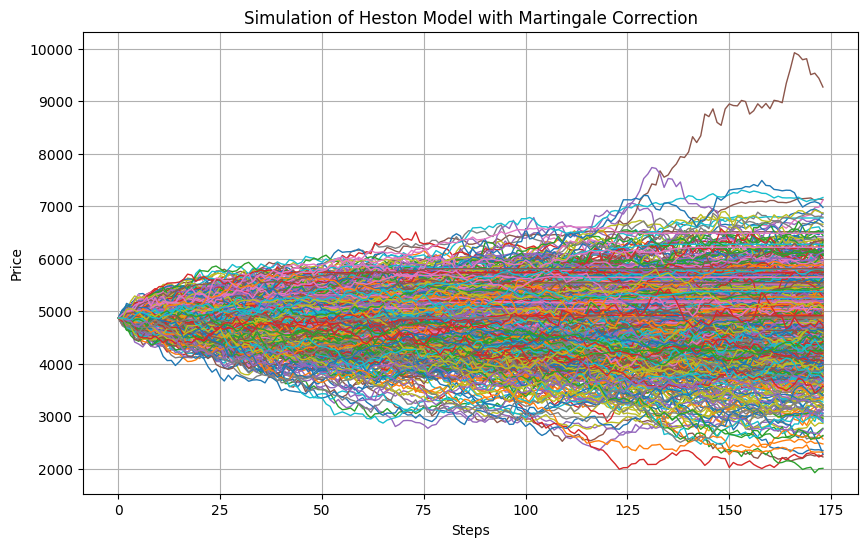

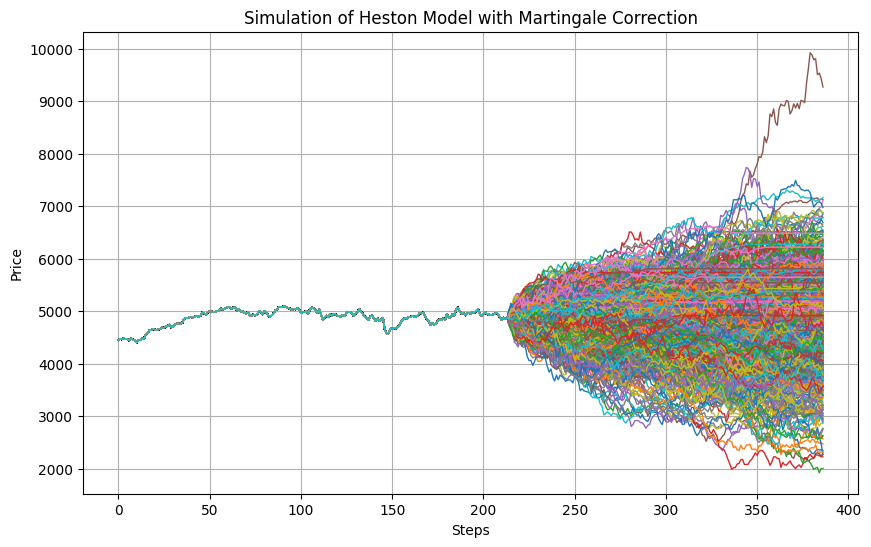

In [ ]:
price_matrix_Heston_QE = heston.QE_simulate(n_trials=100000, n_steps=nb_business, martingale_correction=True)


plt.figure(figsize=(10, 6))
for i in range(1000):  # Plot first 1000 trials
    plt.plot(range(price_matrix_Heston_QE.shape[1]), price_matrix_Heston_QE[i,:], linewidth=1)

plt.title("Simulation of Heston Model with Martingale Correction")
plt.xlabel("Steps")
plt.ylabel("Price")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
appended_price_matrix = np.array([np.concatenate((price_history_9m, inner)) for inner in price_matrix_Heston_QE])

for i in range(1000):  # Plot first 1000 trials
    plt.plot(range(appended_price_matrix.shape[1]), appended_price_matrix[i,:], linewidth=1)

plt.title("Simulation of Heston Model with Martingale Correction")
plt.xlabel("Steps")
plt.ylabel("Price")
plt.grid(True)
plt.show()


## Simulate Heston Model without Martingale Correction

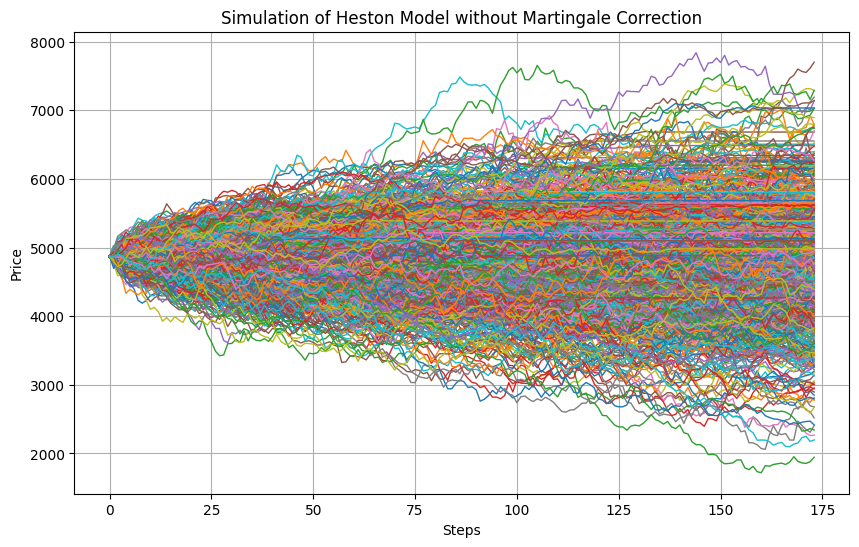

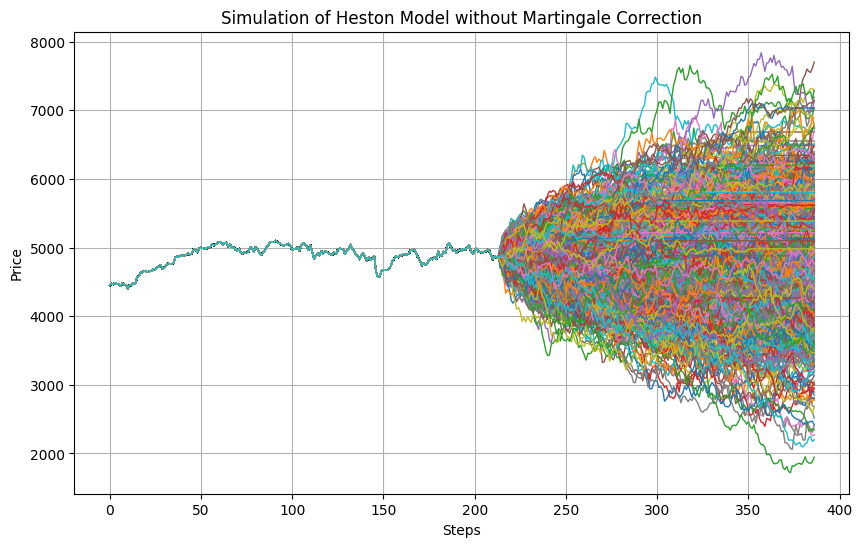

In [ ]:
price_matrix_Heston_QE_wo = heston.QE_simulate(n_trials=100000, n_steps=nb_business, martingale_correction=False)

plt.figure(figsize=(10, 6))
for i in range(1000):  # Plot first 1000 trials
    plt.plot(range(price_matrix_Heston_QE_wo.shape[1]), price_matrix_Heston_QE_wo[i,:], linewidth=1)

plt.title("Simulation of Heston Model without Martingale Correction")
plt.xlabel("Steps")
plt.ylabel("Price")
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
appended_price_matrix = np.array([np.concatenate((price_history_9m, inner)) for inner in price_matrix_Heston_QE_wo])

for i in range(1000):  # Plot first 1000 trials
    plt.plot(range(appended_price_matrix.shape[1]), appended_price_matrix[i,:], linewidth=1)

plt.title("Simulation of Heston Model without Martingale Correction")
plt.xlabel("Steps")
plt.ylabel("Price")
plt.grid(True)
plt.show()

## Simulate Heston Model Antivariates with Martingale Correction

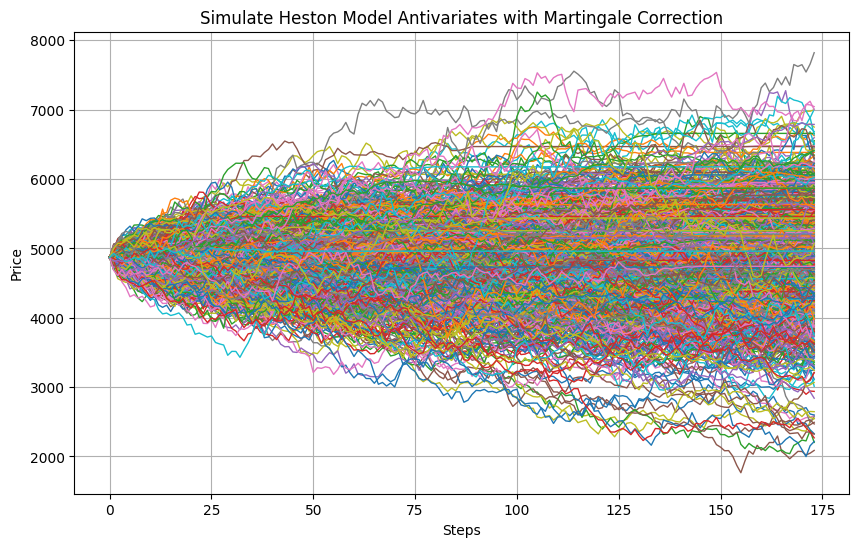

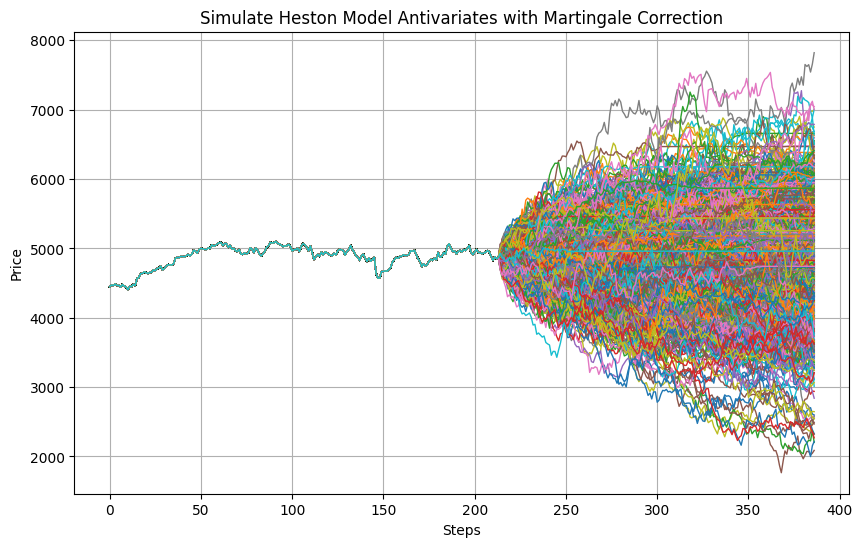

In [ ]:
price_matrix_QE_AV = heston.QE_simulate_AV(n_trials=100000, n_steps=nb_business, martingale_correction=True)

plt.figure(figsize=(10, 6))
for i in range(1000):  # Plot first 1000
    plt.plot(range(price_matrix_QE_AV.shape[1]), price_matrix_QE_AV[i,:], linewidth=1)


plt.title("Simulate Heston Model Antivariates with Martingale Correction")
plt.xlabel("Steps")
plt.ylabel("Price")
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
appended_price_matrix = np.array([np.concatenate((price_history_9m, inner)) for inner in price_matrix_QE_AV])

for i in range(1000):  # Plot first 1000 trials
    plt.plot(range(appended_price_matrix.shape[1]), appended_price_matrix[i,:], linewidth=1)

plt.title("Simulate Heston Model Antivariates with Martingale Correction")
plt.xlabel("Steps")
plt.ylabel("Price")
plt.grid(True)
plt.show()

## Simulate Heston Model Antivariates without Martingale Correction

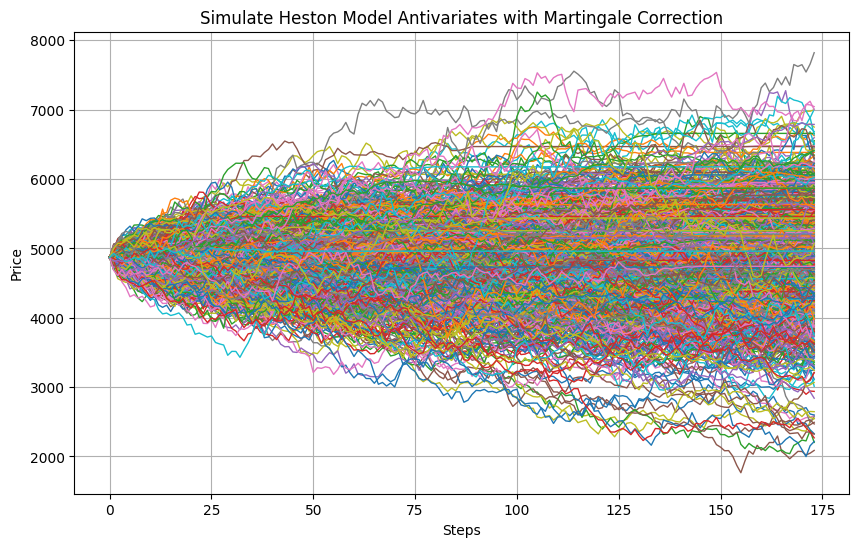

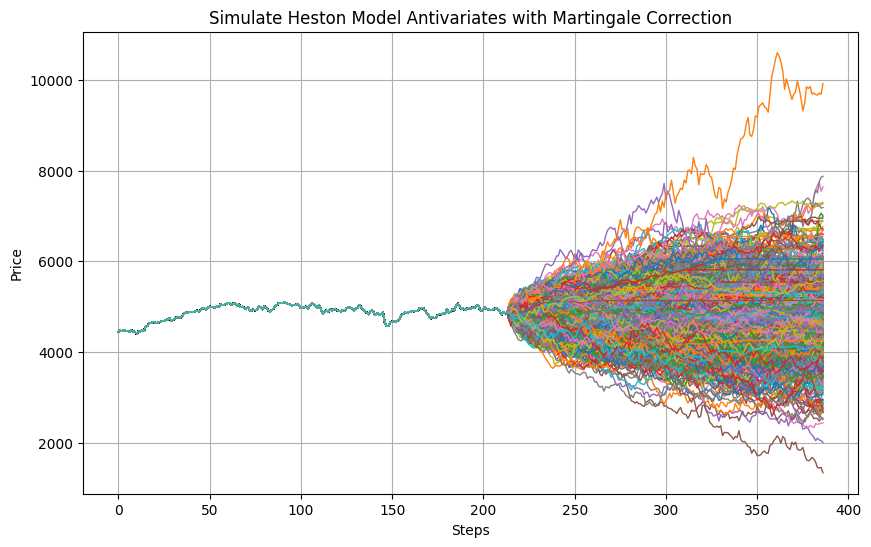

In [ ]:
price_matrix_QE_AV_wo = heston.QE_simulate_AV(n_trials=100000, n_steps=nb_business, martingale_correction=False)

plt.figure(figsize=(10, 6))
for i in range(1000):  # Plot first 10000
    plt.plot(range(price_matrix_QE_AV.shape[1]), price_matrix_QE_AV[i,:], linewidth=1)


plt.title("Simulate Heston Model Antivariates with Martingale Correction")
plt.xlabel("Steps")
plt.ylabel("Price")
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
appended_price_matrix = np.array([np.concatenate((price_history_9m, inner)) for inner in price_matrix_QE_AV_wo])

for i in range(1000):  # Plot first 1000 trials
    plt.plot(range(appended_price_matrix.shape[1]), appended_price_matrix[i,:], linewidth=1)

plt.title("Simulate Heston Model Antivariates with Martingale Correction")
plt.xlabel("Steps")
plt.ylabel("Price")
plt.grid(True)
plt.show()

## Variance Comparison

In [ ]:
mean_payoff_qe, std_payoff_qe, roi_payoff_qe = heston.Pricer(price_matrix_Heston_QE)
mean_payoff_qe_wo, std_payoff_qe_wo, roi_payoff_qe_wo = heston.Pricer(price_matrix_Heston_QE_wo)
mean_payoff_qe_cv, std_payoff_qe_cv, roi_payoff_qe_cv = heston.CVPricer(price_matrix_Heston_QE)
mean_payoff_qe_cv_wo, std_payoff_qe_cv_wo, roi_payoff_qe_cv_wo = heston.CVPricer(price_matrix_Heston_QE_wo)
mean_payoff_qe_av, std_payoff_qe_av, roi_payoff_qe_av = heston.Pricer(price_matrix_QE_AV)
mean_payoff_qe_av_wo, std_payoff_qe_av_wo, roi_payoff_qe_av_wo = heston.Pricer(price_matrix_QE_AV_wo)
mean_payoff_qe_av_cv, std_payoff_qe_av_cv, roi_payoff_qe_av_cv = heston.CVPricer(price_matrix_QE_AV)
mean_payoff_qe_av_cv_wo, std_payoff_qe_av_cv_wo, roi_payoff_qe_av_cv_wo = heston.CVPricer(price_matrix_QE_AV_wo)

print(f'STD Redemption Heston = {std_payoff_qe}, ROI Redemption Heston = {roi_payoff_qe}')
print(f'STD Redemption Heston without Martingale = {std_payoff_qe_wo}, ROI Redemption Heston without Martingale = {roi_payoff_qe_wo}')
print(f'STD Redemption Heston Control Variates = {std_payoff_qe_cv}, ROI Redemption Heston Control Variates = {roi_payoff_qe_cv}')
print(f'STD Redemption Heston Control Variates without Martingale = {std_payoff_qe_cv_wo}, ROI Redemption Heston Control Variates without Martingale = {roi_payoff_qe_cv_wo}')
print(f'STD Redemption Heston Antivariates = {std_payoff_qe_av}, ROI Redemption Heston Antivariates = {roi_payoff_qe_av}')
print(f'STD Redemption Heston Antivariates without Martingale = {std_payoff_qe_av_wo}, ROI Redemption Heston Antivariates without Martingale = {roi_payoff_qe_av_wo}')
print(f'STD Redemption Heston Antivariates Control Variates = {std_payoff_qe_av_cv}, ROI Redemption Heston Antivariates Control Variates = {roi_payoff_qe_av_cv}')
print(f'STD Redemption Heston Antivariates Control Variates without Martingale = {std_payoff_qe_av_cv_wo}, ROI Redemption Heston Antivariates Control Variates without Martingale = {roi_payoff_qe_av_cv_wo}')

STD Redemption Heston = 321.3084690250486, ROI Redemption Heston = 1.604151978546064
STD Redemption Heston without Martingale = 322.01675478326746, ROI Redemption Heston without Martingale = 1.6048233935750287
STD Redemption Heston Control Variates = 52.98499549879807, ROI Redemption Heston Control Variates = 1.6106751972309086
STD Redemption Heston Control Variates without Martingale = 45.97936292467955, ROI Redemption Heston Control Variates without Martingale = 1.587192990061
STD Redemption Heston Antivariates = 322.55003180981214, ROI Redemption Heston Antivariates = 1.6037405741344717
STD Redemption Heston Antivariates without Martingale = 322.73552375043926, ROI Redemption Heston Antivariates without Martingale = 1.604165895510044
STD Redemption Heston Antivariates Control Variates = 46.08424470980999, ROI Redemption Heston Antivariates Control Variates = 1.6359624835428948
STD Redemption Heston Antivariates Control Variates without Martingale = 47.79159705914915, ROI Redemption 

**Back-testing from 1 Aug 24 to 31 Oct 24 (GBM Exact)**


In [ ]:
underlying_ticker = yf.Ticker("^STOXX50E")

# Define start and end dates
start_date = "2024-08-01"
end_date = "2024-10-31"
# Create a market calendar for Frankfurt (XETR)
eurocalendar = mcal.get_calendar('XETR')

# Generate the list of business days between start and end date
business_days = eurocalendar.valid_days(start_date=start_date, end_date=end_date).date

backtesting_payoffs = []
Nsim = 1000

for date in business_days:
  start_date = get_ecb_business_days_ago(date, 273).date()
  end_date = date

  trading_days = business_days_between(start_date, "2025-07-14")
  T = trading_days/252
  print(trading_days)
  underlying_asset_fixed_window_bt = underlying_ticker.history(start = start_date, end = end_date)

  es50_prices = underlying_asset_fixed_window_bt['Close']
  # Set precision (for example, 10 decimal places)
  getcontext().prec = 10

  # Convert prices to Decimal for high precision
  es50_prices_decimal = [Decimal(price) for price in es50_prices]

  # Calculate log prices using Decimal
  es50_logprices = [Decimal(math.log(price)) for price in es50_prices_decimal]

  # Convert to a NumPy array for easy indexing and calculations
  es50_logprices = np.array(es50_logprices, dtype=object)  # Use dtype=object to hold Decimal

  # Length of prices
  n0 = len(es50_prices)
  print(n0)
  # Calculate log returns
  es50_logreturns = es50_logprices[1:n0] - es50_logprices[0:n0 - 1]

  # Optionally, convert HSIlogreturns to a more usable format
  # Here, we convert back to floats if needed for further calculations
  es50_logreturns_float = np.array([float(r) for r in es50_logreturns])

  #v = np.mean(es50_logreturns_float) / dt
  input_date = date
  input_date = pd.to_datetime(date).date()
  r = ecbdata.loc[ecbdata['DATE'] == input_date,'Close'].iloc[0]/100
  v = r - sigma**2/2
  sigma = np.std(es50_logreturns_float) / np.sqrt(dt)
  print(v)
  #Simulation (GBM) based on real-world condition for today's price
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)
  updated_array = np.array([np.concatenate((es50_prices, inner)) for inner in simulation_exact])
  specific_date = (end_date - pd.DateOffset(days=1)).date()

  try:
    input_date = date
    input_date = pd.to_datetime(date).date()
    r = ecbdata.loc[ecbdata['DATE'] == input_date,'Close'].iloc[0]/100
    print(r)
    #Collate payoffs of N simulated paths
    payoff_exact = []
    for i in range(0,Nsim):
      payoff_exact.append(payoff(1,updated_array[i]))
    Tminust= (business_days_between(end_date,"2025-07-14"))/252
    discount_factor = math.exp(-r*Tminust)
    payoff_exact_discounted = [payoff_exact[i]*discount_factor for i in range(len(payoff_exact))]
    PV_Payoff = sum(payoff_exact_discounted)/len(payoff_exact_discounted)
    backtesting_payoffs.append(PV_Payoff)
  except:
    pass


514
269
0.02761498211787732


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03664
513
268
0.02884360026667268


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03664
512
268
0.02882262233487911


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03664
511
268
0.027669401264253202


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.036629999999999996
510
268
0.027700022571000266


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.036629999999999996
509
268
0.027742876982833488


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03665
508
268
0.02753735279316431


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.036629999999999996
507
268
0.02759581426272819


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03664
506
268
0.027598661733342238


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03664
505
268
0.027580021694264184


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03662
504
268
0.02757240981728636


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03662
503
268
0.027578125150715255


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03664
502
268
0.027451909313905766


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03664
501
268
0.02743348274645241


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03664
500
268
0.02746103211983075


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.036629999999999996
499
268
0.027708435167483652


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03664
498
268
0.027702250577973167


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03664
497
268
0.027712438880049282


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03665
496
269
0.028156548994714346


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03665
495
269
0.02819397987472394


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03666
494
269
0.028202908766820224


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03664
493
269
0.028117472275719157


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.036539999999999996
492
269
0.02816783243115867


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03664
491
269
0.028221061601282224


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.036629999999999996
490
269
0.0282355161732325


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.036629999999999996
489
269
0.028253151258919154


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03662
488
269
0.028279517631344446


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.036629999999999996
487
269
0.02825608477260931


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.036629999999999996
486
269
0.028185222451092055


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03664
485
269
0.028154961856885548


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03664
484
269
0.028219759526585807


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03664
483
269
0.02821294449948681


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.036629999999999996
482
269
0.028157845442876746


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03662
481
269
0.028201739099157914


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03665
480
269
0.02570523629045879


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.034159999999999996
479
269
0.025700989745110994


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.034140000000000004
478
269
0.02566548051172425


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03412
477
269
0.025545146153617925


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.034140000000000004
476
269
0.02547145704891131


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03415
475
269
0.025483029996979406


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.034159999999999996
474
269
0.02542933501102781


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03415
473
269
0.0254229816578006


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03415
472
269
0.02513143396846596


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.0341
471
269
0.025177485331126792


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.034159999999999996
470
269
0.02505543613894784


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.0341
469
269
0.024989578430434423


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03407
468
269
0.025063748412205555


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.034140000000000004
467
269
0.02502084570192156


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03413
466
269
0.025017946832194524


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.034140000000000004
465
269
0.025037182896331354


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03415
464
269
0.025091932717794453


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.034140000000000004
463
269
0.025068078468492946


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03413
462
269
0.025132430484107987


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03413
461
269
0.025115612689954388


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03413
460
269
0.025128427282510107


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.034140000000000004
459
269
0.025073474606262768


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03415
458
269
0.02504271914642841


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03415
457
269
0.02506625059998237


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03415
456
269
0.0250979290294757


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.034159999999999996
455
269
0.02255313268864077


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03166
454
269
0.022572809377988362


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03166
453
269
0.02256816420962065


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03166
452
269
0.022589164427213364


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03164
451
269
0.022644589414296746


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03164
450
269
0.022644320560027086


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.03165
449
269
0.022534158436117665


<ipython-input-34-a89562e9f600>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexact(Nsim, es50_prices[n0-1],v,sigma,dt,T)


0.031549999999999995


# Back-testing from 1 Aug 24 to 31 Oct 24 (GBM Exact)

In [ ]:
underlying_ticker = yf.Ticker("^STOXX50E")

# Define start and end dates
start_date = "2024-08-01"
end_date = "2024-10-31"
# Create a market calendar for Frankfurt (XETR)
eurocalendar = mcal.get_calendar('XETR')

# Generate the list of business days between start and end date
business_days = eurocalendar.valid_days(start_date=start_date, end_date=end_date).date

backtesting_payoffsAV = []
Nsim = 1000

for date in business_days:
  start_date = get_ecb_business_days_ago(date, 273).date()
  end_date = date

  trading_days = business_days_between(start_date, "2025-07-14")
  T = trading_days/252
  print(trading_days)
  underlying_asset_fixed_window_bt = underlying_ticker.history(start = start_date, end = end_date)

  es50_prices = underlying_asset_fixed_window_bt['Close']
  # Set precision (for example, 10 decimal places)
  getcontext().prec = 10

  # Convert prices to Decimal for high precision
  es50_prices_decimal = [Decimal(price) for price in es50_prices]

  # Calculate log prices using Decimal
  es50_logprices = [Decimal(math.log(price)) for price in es50_prices_decimal]

  # Convert to a NumPy array for easy indexing and calculations
  es50_logprices = np.array(es50_logprices, dtype=object)  # Use dtype=object to hold Decimal

  # Length of prices
  n0 = len(es50_prices)
  print(n0)
  # Calculate log returns
  es50_logreturns = es50_logprices[1:n0] - es50_logprices[0:n0 - 1]

  # Optionally, convert HSIlogreturns to a more usable format
  # Here, we convert back to floats if needed for further calculations
  es50_logreturns_float = np.array([float(r) for r in es50_logreturns])

  #v = np.mean(es50_logreturns_float) / dt
  input_date = date
  input_date = pd.to_datetime(date).date()
  r = ecbdata.loc[ecbdata['DATE'] == input_date,'Close'].iloc[0]/100
  v = r - sigma**2/2
  sigma = np.std(es50_logreturns_float) / np.sqrt(dt)
  print(v)
  #Simulation (GBM) based on real-world condition for today's price
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)
  updated_array = np.array([np.concatenate((es50_prices, inner)) for inner in simulation_exact])
  specific_date = (end_date - pd.DateOffset(days=1)).date()

  try:
    input_date = date
    input_date = pd.to_datetime(date).date()
    r = ecbdata.loc[ecbdata['DATE'] == input_date,'Close'].iloc[0]/100
    print(r)
    #Collate payoffs of N simulated paths
    payoff_exact = []
    for i in range(0,Nsim):
      payoff_exact.append(payoff(1,updated_array[i]))
    Tminust= (business_days_between(end_date,"2025-07-14"))/252
    discount_factor = math.exp(-r*Tminust)
    payoff_exact_discounted = [payoff_exact[i]*discount_factor for i in range(len(payoff_exact))]
    PV_Payoff = sum(payoff_exact_discounted)/len(payoff_exact_discounted)
    backtesting_payoffsAV.append(PV_Payoff)
  except:
    pass

514
269
0.027584152000700114


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03664
513
268
0.02884360026667268


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03664
512
268
0.02882262233487911


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03664
511
268
0.027669401264253202


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.036629999999999996
510
268
0.027700022571000266


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.036629999999999996
509
268
0.027742876982833488


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03665
508
268
0.02753735279316431


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.036629999999999996
507
268
0.02759581426272819


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03664
506
268
0.027598661733342238


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03664
505
268
0.027580021694264184


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03662
504
268
0.02757240981728636


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03662
503
268
0.027578125150715255


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03664
502
268
0.027451909313905766


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03664
501
268
0.02743348274645241


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03664
500
268
0.02746103211983075


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.036629999999999996
499
268
0.027708435167483652


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03664
498
268
0.027702250577973167


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03664
497
268
0.027712438880049282


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03665
496
269
0.028156548994714346


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03665
495
269
0.02819397987472394


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03666
494
269
0.028202908766820224


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03664
493
269
0.028117472275719157


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.036539999999999996
492
269
0.02816783243115867


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03664
491
269
0.028221061601282224


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.036629999999999996
490
269
0.0282355161732325


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.036629999999999996
489
269
0.028253151258919154


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03662
488
269
0.028279517631344446


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.036629999999999996
487
269
0.02825608477260931


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.036629999999999996
486
269
0.028185222451092055


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03664
485
269
0.028154961856885548


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03664
484
269
0.028219759526585807


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03664
483
269
0.02821294449948681


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.036629999999999996
482
269
0.028157845442876746


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03662
481
269
0.028201739099157914


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03665
480
269
0.02570523629045879


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.034159999999999996
479
269
0.025700989745110994


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.034140000000000004
478
269
0.02566548051172425


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03412
477
269
0.025545146153617925


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.034140000000000004
476
269
0.02547145704891131


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03415
475
269
0.025483029996979406


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.034159999999999996
474
269
0.02542933501102781


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03415
473
269
0.0254229816578006


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03415
472
269
0.02513143396846596


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.0341
471
269
0.025177485331126792


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.034159999999999996
470
269
0.02505543613894784


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.0341
469
269
0.024989578430434423


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03407
468
269
0.025063748412205555


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.034140000000000004
467
269
0.02502084570192156


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03413
466
269
0.025017946832194524


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.034140000000000004
465
269
0.025037182896331354


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03415
464
269
0.025091932717794453


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.034140000000000004
463
269
0.025068078468492946


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03413
462
269
0.025132430484107987


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03413
461
269
0.025115612689954388


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03413
460
269
0.025128427282510107


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.034140000000000004
459
269
0.025073474606262768


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03415
458
269
0.02504271914642841


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03415
457
269
0.02506625059998237


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03415
456
269
0.0250979290294757


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.034159999999999996
455
269
0.02255313268864077


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03166
454
269
0.022572809377988362


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03166
453
269
0.02256816420962065


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03166
452
269
0.022589164427213364


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03164
451
269
0.022644589414296746


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03164
450
269
0.022644320560027086


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.03165
449
269
0.022534158436117665


<ipython-input-35-bb335d0826ee>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulation_exact = SimGBMexactAV(int(Nsim/2), es50_prices[n0-1],v,sigma,dt,T)


0.031549999999999995


Adjustments

In [ ]:
def pricing_backtest(path, history_price, barrier = 1743.525, S0 = 3487.05):
    price_min = np.min(history_price)
    redemptions = np.zeros(len(path))
    for i, price in enumerate(path):
        if price_min > barrier or price > barrier:
            redemptions[i] = max(1000, 1000 * (1 + 1.5 * (price - S0) / S0))
        else:
            redemptions[i] = max(0, 1000 * (1 + (price - S0) / S0))
    return redemptions
actual_price = pricing_backtest(underlying_asset_backtestlist, underlying_asset_backtestlist[0])

# **Plotting of Graphs for Backtest against actual derivative price**

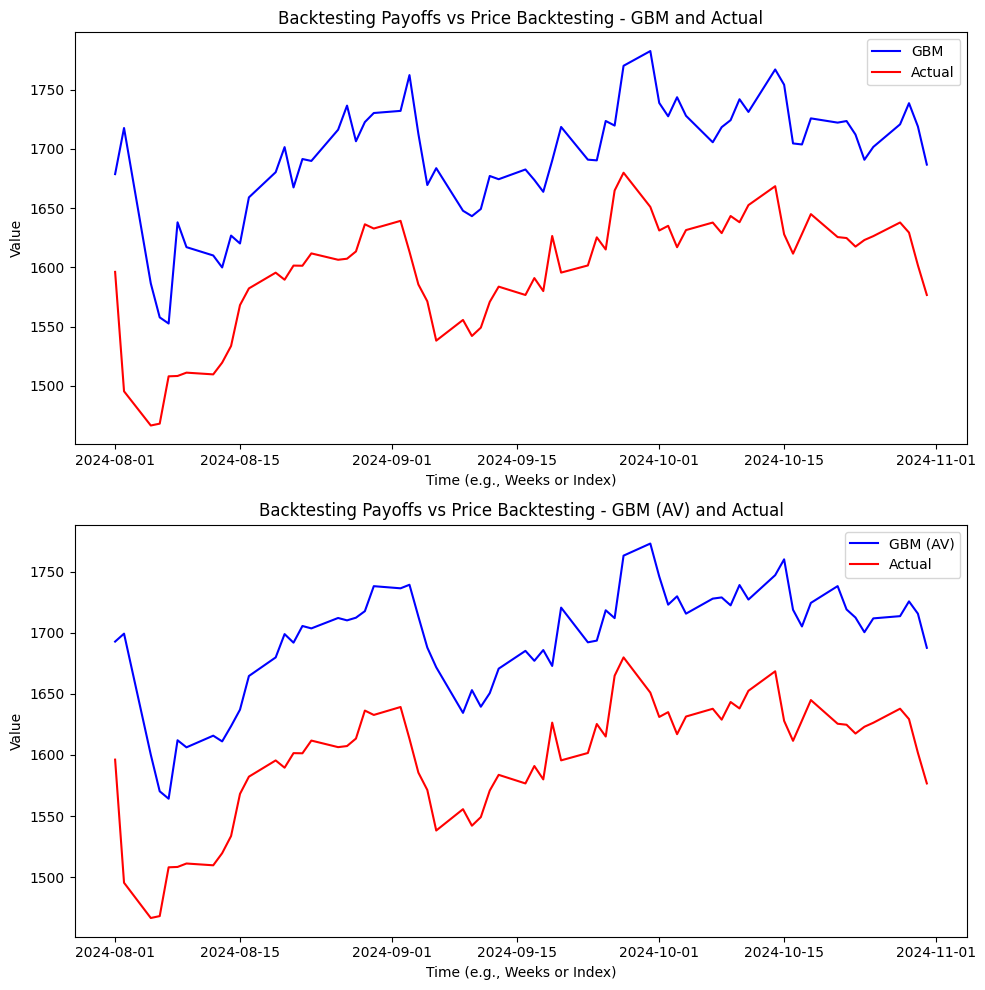

In [ ]:
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# ax1.plot(business_days, backtesting_payoffs, label="GBM", color="blue", linestyle="-")
# ax1.plot(business_days, actual_price, label="Actual", color="red", linestyle="-")
# ax1.set_xlabel("Time (e.g., Weeks or Index)")
# ax1.set_ylabel("Value")
# ax1.set_title("Backtesting Payoffs vs Price Backtesting - GBM and Actual")
# ax1.legend()

# ax2.plot(business_days, backtesting_payoffsAV, label="GBM (AV)", color="blue", linestyle="-")
# ax2.plot(business_days, actual_price, label="Actual", color="red", linestyle="-")
# ax2.set_xlabel("Time (e.g., Weeks or Index)")
# ax2.set_ylabel("Value")
# ax2.set_title("Backtesting Payoffs vs Price Backtesting - GBM (AV) and Actual")
# ax2.legend()

# plt.tight_layout()
# plt.show()

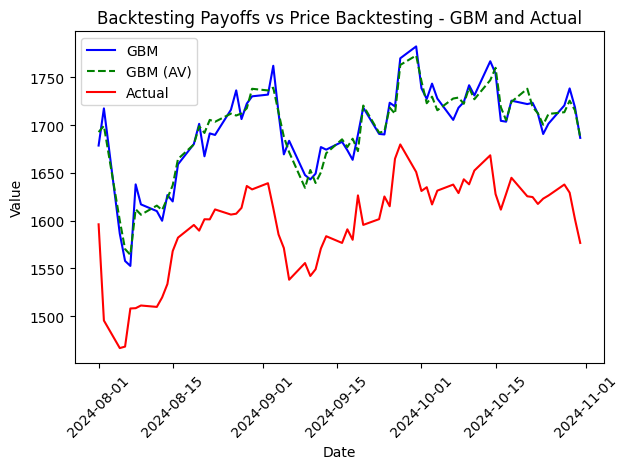

In [ ]:
plt.plot(business_days, backtesting_payoffs, label="GBM", color="blue", linestyle="-")
plt.plot(business_days, backtesting_payoffsAV, label="GBM (AV)", color="green", linestyle="--")
plt.plot(business_days, actual_price, label="Actual", color="red", linestyle="-")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Backtesting Payoffs vs Price Backtesting - GBM and Actual")
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
mse = np.mean((backtesting_payoffs - actual_price) ** 2)
print(np.sqrt(mse))
print(mse)

100.64280694534474
10128.974589837933


In [ ]:
mse_av = np.mean((backtesting_payoffsAV - actual_price) ** 2)
print(np.sqrt(mse_av))
print(mse_av)

99.94267774343425
9988.538834527946


# Backtest Heston Model

### Load Data

In [ ]:
underlying_ticker = yf.Ticker("^STOXX50E")
start_date = '2024-07-31'

end_date = '2024-11-01'
price_history_matrix = underlying_ticker.history(period="1y", start = '2022-07-12', end = end_date)
price_history = price_history_matrix['Close']

underlying_asset_full_duration = underlying_ticker.history(period="1y", start = start_date, end = end_date)
price_backtest_true = underlying_asset_full_duration['Close']

print(len(price_backtest_true))


eurex = mcal.get_calendar('EUREX')
product_lifetime = eurex.schedule(start_date='2024-07-31', end_date='2025-07-14')
print(len(product_lifetime))


66
243


In [ ]:
start_date = '2024-07-31'
end_date = '2024-11-01'

window_size = 252
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

start_date = start_date.tz_localize('Europe/Zurich')
end_date = end_date.tz_localize('Europe/Zurich')

price_history_matrix = underlying_ticker.history(period="1y", start = '2022-07-12', end = end_date)
price_history = price_history_matrix['Close'].values

simulation_dates = price_history_matrix.index[(price_history_matrix.index >= start_date) & (price_history_matrix.index <= end_date)]

print(f"{len(simulation_dates)} days")
print(simulation_dates)

66 days
DatetimeIndex(['2024-07-31 00:00:00+02:00', '2024-08-02 00:00:00+02:00',
               '2024-08-05 00:00:00+02:00', '2024-08-06 00:00:00+02:00',
               '2024-08-07 00:00:00+02:00', '2024-08-08 00:00:00+02:00',
               '2024-08-09 00:00:00+02:00', '2024-08-12 00:00:00+02:00',
               '2024-08-13 00:00:00+02:00', '2024-08-14 00:00:00+02:00',
               '2024-08-15 00:00:00+02:00', '2024-08-16 00:00:00+02:00',
               '2024-08-19 00:00:00+02:00', '2024-08-20 00:00:00+02:00',
               '2024-08-21 00:00:00+02:00', '2024-08-22 00:00:00+02:00',
               '2024-08-23 00:00:00+02:00', '2024-08-26 00:00:00+02:00',
               '2024-08-27 00:00:00+02:00', '2024-08-28 00:00:00+02:00',
               '2024-08-29 00:00:00+02:00', '2024-08-30 00:00:00+02:00',
               '2024-09-02 00:00:00+02:00', '2024-09-03 00:00:00+02:00',
               '2024-09-04 00:00:00+02:00', '2024-09-05 00:00:00+02:00',
               '2024-09-06 00:00:00+02:00',

### Backtest Window from Historical Data

In [ ]:
# We shall sample a window of size 252 from the historical data (EXCLUDING the current date)
backtest_windows = []   # Prices only
backtest_windows_with_dates = []
previous_window_end_date = None

for window_end_date in simulation_dates:
    # For each date the product was prices, we need 252 points BEFORE this date
    try:
        window_start_index = price_history_matrix.index.get_loc(window_end_date) - window_size
    except:
        window_start_index = price_history_matrix.index.get_loc(previous_window_end_date) - window_size + 1
        print(f"Asset not priced on {window_end_date}. Using data up till the previous date!")

    assert window_start_index >= 0

    # Slice the dataset according to the window
    window_start_date = price_history_matrix.index[window_start_index]
    window_asset_data = price_history_matrix[(price_history_matrix.index >= window_start_date) & (price_history_matrix.index < window_end_date)]

    # Collect all the windows
    assert len(window_asset_data) == window_size
    backtest_windows_with_dates.append(window_asset_data)   # For validatiuon purposes
    backtest_windows.append(np.array(window_asset_data['Close']))

    # For handling edge cases in the try-except block
    previous_window_end_date = window_end_date

print(f"Collected data for {len(backtest_windows)} windows of size {window_size} each.")

Collected data for 66 windows of size 252 each.


 ### Get Risk Free Rate from European Central Bank
 https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html

In [ ]:
# ECB rates
raw_ecb = pd.read_csv('/content/drive/MyDrive/MH4518/data/rate_yield_data.csv')

clean_ecb = raw_ecb[['DATA_TYPE_FM', 'TIME_PERIOD', 'OBS_VALUE']]
clean_ecb.loc[:, 'TIME_PERIOD'] = pd.to_datetime(clean_ecb['TIME_PERIOD']).dt.tz_localize('Europe/Zurich')
clean_ecb = clean_ecb[clean_ecb['DATA_TYPE_FM'].str.startswith('BETA') | clean_ecb['DATA_TYPE_FM'].str.startswith('TAU')]
clean_ecb.head()

DATA_TYPE_FM                TIME_PERIOD  OBS_VALUE
0        BETA0  2024-01-02 00:00:00+01:00   0.988688
1        BETA0  2024-01-03 00:00:00+01:00   1.020152
2        BETA0  2024-01-04 00:00:00+01:00   1.025413
3        BETA0  2024-01-05 00:00:00+01:00   1.039320
4        BETA0  2024-01-08 00:00:00+01:00   1.028809

### Create Yield Curves using Nelson Siegel Svensson

In [ ]:
curves = []
for date in simulation_dates:
    print(f"Processing date {date}")

    date_data = clean_ecb[clean_ecb['TIME_PERIOD'] == date]

    # Extract parameters, handling potential missing data
    interest_rate_values = []
    parameter_names = ['BETA0', 'BETA1', 'BETA2', 'BETA3', 'TAU1', 'TAU2']
    for param_name in parameter_names:
        value = date_data[date_data['DATA_TYPE_FM'] == param_name]['OBS_VALUE'].iloc[0]
        interest_rate_values.append(value)

    curve = NelsonSiegelSvenssonCurve(beta0=interest_rate_values[0], beta1=interest_rate_values[1], beta2=interest_rate_values[2], beta3=interest_rate_values[3], tau1=interest_rate_values[4], tau2=interest_rate_values[5])
    curves.append(curve)

Processing date 2024-07-31 00:00:00+02:00
Processing date 2024-08-02 00:00:00+02:00
Processing date 2024-08-05 00:00:00+02:00
Processing date 2024-08-06 00:00:00+02:00
Processing date 2024-08-07 00:00:00+02:00
Processing date 2024-08-08 00:00:00+02:00
Processing date 2024-08-09 00:00:00+02:00
Processing date 2024-08-12 00:00:00+02:00
Processing date 2024-08-13 00:00:00+02:00
Processing date 2024-08-14 00:00:00+02:00
Processing date 2024-08-15 00:00:00+02:00
Processing date 2024-08-16 00:00:00+02:00
Processing date 2024-08-19 00:00:00+02:00
Processing date 2024-08-20 00:00:00+02:00
Processing date 2024-08-21 00:00:00+02:00
Processing date 2024-08-22 00:00:00+02:00
Processing date 2024-08-23 00:00:00+02:00
Processing date 2024-08-26 00:00:00+02:00
Processing date 2024-08-27 00:00:00+02:00
Processing date 2024-08-28 00:00:00+02:00
Processing date 2024-08-29 00:00:00+02:00
Processing date 2024-08-30 00:00:00+02:00
Processing date 2024-09-02 00:00:00+02:00
Processing date 2024-09-03 00:00:0

### Helper Function

In [ ]:
def get_stats(variances):
  mu = np.mean(variances)
  sigma = np.std(variances, ddof=1)
  reversion_rate = 1
  return mu, sigma, reversion_rate, variances[len(variances)-1]


def get_lognormal_statistics(prices):
  log_data = np.log(prices)
  log_returns = log_data[1:] - log_data[:-1]
  mu = np.mean(log_returns)
  dev_2 = (log_returns-mu)**2
  mu, _, _, var_init = get_stats(dev_2)
  return mu, var_init

### Simulation

In [ ]:
price_history_m = underlying_ticker.history(period="1y", start = '2022-07-12', end = '2024-08-01')
price_history_m = price_history_m['Close']

In [ ]:
Nsim = 100000
price_backtest_heston_qe_av_without_martingale = []
price_backtest_heston_qe_without_martingale = []
price_backtest_heston_qe_av_with_martingale = []
price_backtest_heston_qe_with_martingale = []

derivative_backtest_heston_qe_with_martingale = []
derivative_backtest_heston_qe_av_with_martingale = []
derivative_backtest_heston_qe_av_cv_with_martingale = []
derivative_backtest_heston_qe_cv_with_martingale = []

derivative_backtest_heston_qe_without_martingale = []
derivative_backtest_heston_qe_av_without_martingale = []
derivative_backtest_heston_qe_av_cv_without_martingale = []
derivative_backtest_heston_qe_cv_without_martingale = []

opt_params_diffevol_dnn = [ 6.20792492e-05 , 1.03492111e-01, -7.78000323e-01 , 5.10080353e-03, 6.90092809e-03]

for date, prices in zip(simulation_dates, backtest_windows):
    delta_t = 1/252

    date_index = simulation_dates.get_loc(date)

    curve_fit = curves[date_index]


    delta = len(product_lifetime[date_index:])
    tau = delta / 252 ### time diff in years

    num_steps =  int(tau/delta_t)

    rate = curve_fit(tau) ### yearly interest

    mu, var_inint= get_lognormal_statistics(prices)  ### all daily indicators

    heston = Heston(S0 = prices[-1], T = tau, r = rate, q = 3/100, mu = mu, theta = opt_params_diffevol_dnn[0], sigma = opt_params_diffevol_dnn[1], rho = opt_params_diffevol_dnn[2], kappa = opt_params_diffevol_dnn[3], V0 =var_inint, barrier = 1743.525, price_history_matrix = price_history_m.values)
    paths_qe_av_with_martingale = heston.QE_simulate_AV(n_trials=Nsim, n_steps=num_steps, martingale_correction=True)
    path_qe_with_martingale = heston.QE_simulate(n_trials=Nsim, n_steps=num_steps, martingale_correction=True)
    paths_qe_av_without_martingale = heston.QE_simulate_AV(n_trials=Nsim, n_steps=num_steps, martingale_correction=False)
    path_qe_without_martingale = heston.QE_simulate(n_trials=Nsim, n_steps=num_steps, martingale_correction=False)

    expected_price_qe_av_with_martingale = np.mean(paths_qe_av_with_martingale[:,-1])
    expected_price_qe_with_martingale = np.mean(path_qe_with_martingale[:,-1])
    expected_price_qe_av_without_martingale = np.mean(paths_qe_av_without_martingale[:,-1])
    expected_price_qe_without_martingale = np.mean(path_qe_without_martingale[:,-1])

    price_backtest_heston_qe_av_with_martingale.append(expected_price_qe_av_with_martingale)
    price_backtest_heston_qe_with_martingale.append(expected_price_qe_with_martingale)
    price_backtest_heston_qe_av_without_martingale.append(expected_price_qe_av_without_martingale)
    price_backtest_heston_qe_without_martingale.append(expected_price_qe_without_martingale)

    derivative_qe_av_with_martingale, _ , _ = heston.Pricer(paths_qe_av_with_martingale)
    derivative_qe_with_martingale, _ , _ = heston.Pricer(path_qe_with_martingale)
    derivative_qe_av_cv_with_martingale, _ , _ = heston.CVPricer(paths_qe_av_with_martingale)
    derivative_qe_cv_with_martingale, _ , _ = heston.CVPricer(path_qe_with_martingale)

    derivative_qe_av_without_martingale, _ , _ = heston.Pricer(paths_qe_av_without_martingale)
    derivative_qe_without_martingale, _ , _  = heston.Pricer(path_qe_without_martingale)
    derivative_qe_av_cv_without_martingale, _ , _  = heston.CVPricer(paths_qe_av_without_martingale)
    derivative_qe_cv_without_martingale, _ , _  = heston.CVPricer(path_qe_without_martingale)


    derivative_backtest_heston_qe_with_martingale.append(derivative_qe_with_martingale)
    derivative_backtest_heston_qe_av_with_martingale.append(derivative_qe_av_with_martingale)
    derivative_backtest_heston_qe_av_cv_with_martingale.append(derivative_qe_av_cv_with_martingale)
    derivative_backtest_heston_qe_cv_with_martingale.append(derivative_qe_cv_with_martingale)

    derivative_backtest_heston_qe_without_martingale.append(derivative_qe_without_martingale)
    derivative_backtest_heston_qe_av_without_martingale.append(derivative_qe_av_without_martingale)
    derivative_backtest_heston_qe_av_cv_without_martingale.append(derivative_qe_av_cv_without_martingale)
    derivative_backtest_heston_qe_cv_without_martingale.append(derivative_qe_cv_without_martingale)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
/content/drive/MyDrive/MH4518/Heston.py:210: RuntimeWarning: invalid value encountered in multiply
  S[t] = S[t - 1] + K0      + K1 * V[t - 1] + K2 * V[t] + np.sqrt(K3 * V[t - 1] + K4 * V[t]) * Zs[t]


/content/drive/MyDrive/MH4518/Heston.py:298: RuntimeWarning: divide by zero encountered in divide
  V[t, ~idx] = np.where(idx2, 0, (1 / beta) * np.log((1 - p) / (1 - Uv[t, ~idx])))
/content/drive/MyDrive/MH4518/Heston.py:304: RuntimeWarning: invalid value encountered in add
  S[t] = S[t - 1] + K0_star + K1 * V[t - 1] + K2 * V[t] + np.sqrt(K3 * V[t - 1] + K4 * V[t]) * Zs[t]
/content/drive/MyDrive/MH4518/Heston.py:284: RuntimeWarning: invalid value encountered in divide
  psi = s2 / m ** 2


/content/drive/MyDrive/MH4518/Heston.py:306: RuntimeWarning: invalid value encountered in add
  S[t] = S[t - 1] + K0      + K1 * V[t - 1] + K2 * V[t] + np.sqrt(K3 * V[t - 1] + K4 * V[t]) * Zs[t]


/content/drive/MyDrive/MH4518/Heston.py:208: RuntimeWarning: invalid value encountered in multiply
  S[t] = S[t - 1] + K0_star + K1 * V[t - 1] + K2 * V[t] + np.sqrt(K3 * V[t - 1] + K4 * V[t]) * Zs[t]


### Comparison Underlying Asset Price

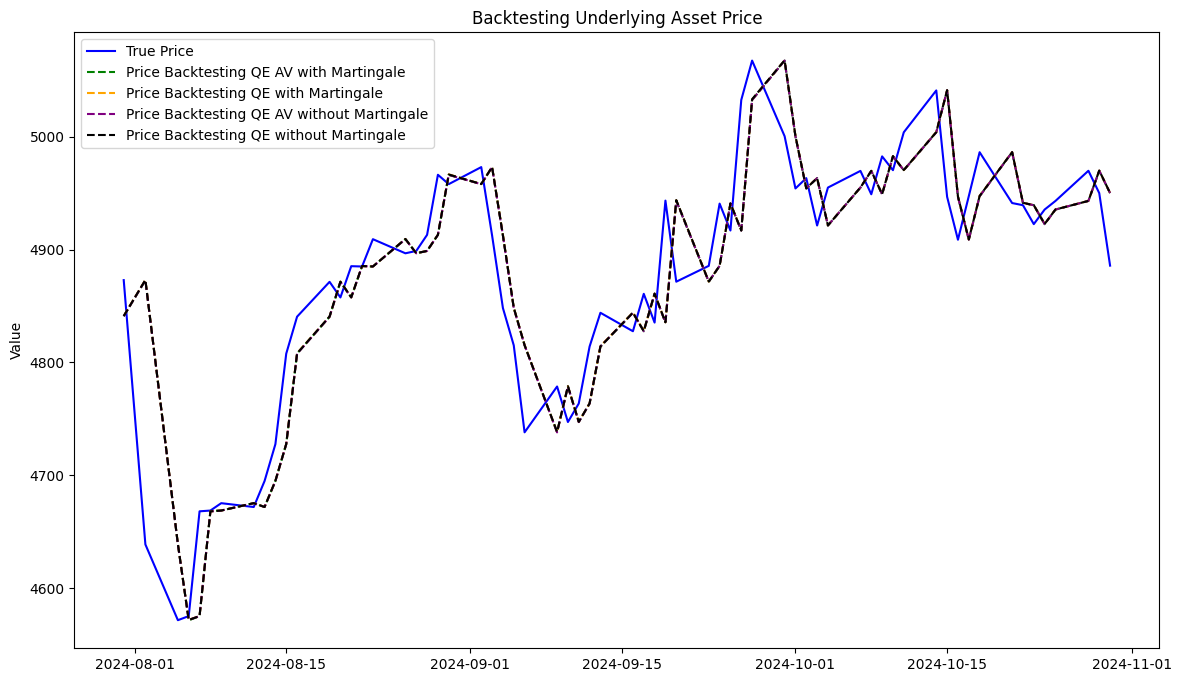

RMSE for QE AV with Martingale: 52.287873652583826
RMSE for QE with Martingale: 52.32171352087677
RMSE for QE AV without Martingale: 52.29728817894962
RMSE for QE without Martingale: 52.325390924593876


In [ ]:
plt.figure(figsize=(14,8))

plt.plot(price_backtest_true.index[:-1], price_backtest_true[:-1], label="True Price", color="blue", linestyle="-")
plt.plot(price_backtest_true.index[:-1], price_backtest_heston_qe_av_with_martingale[:-1], label="Price Backtesting QE AV with Martingale", color="green", linestyle="--")
plt.plot(price_backtest_true.index[:-1], price_backtest_heston_qe_with_martingale[:-1], label="Price Backtesting QE with Martingale", color="orange", linestyle="--")
plt.plot(price_backtest_true.index[:-1], price_backtest_heston_qe_av_without_martingale[:-1], label="Price Backtesting QE AV without Martingale", color="purple", linestyle="--")
plt.plot(price_backtest_true.index[:-1], price_backtest_heston_qe_without_martingale[:-1], label="Price Backtesting QE without Martingale", color="black", linestyle="--")

plt.ylabel("Value")
plt.title("Backtesting Underlying Asset Price")
plt.legend()

plt.show()
mse_qe_av_with_martingale = root_mean_squared_error(price_backtest_true[:-1], price_backtest_heston_qe_av_with_martingale[:-1])
mse_qe_with_martingale = root_mean_squared_error(price_backtest_true[:-1], price_backtest_heston_qe_with_martingale[:-1])
mse_qe_av_without_martingale = root_mean_squared_error(price_backtest_true[:-1], price_backtest_heston_qe_av_without_martingale[:-1])
mse_qe_without_martingale = root_mean_squared_error(price_backtest_true[:-1], price_backtest_heston_qe_without_martingale[:-1])

print(f"RMSE for QE AV with Martingale: {mse_qe_av_with_martingale}")
print(f"RMSE for QE with Martingale: {mse_qe_with_martingale}")
print(f"RMSE for QE AV without Martingale: {mse_qe_av_without_martingale}")
print(f"RMSE for QE without Martingale: {mse_qe_without_martingale}")

In [ ]:
def pricing_backtest(path, history_price, barrier = 1743.525, S0 = 3487.05):
    price_min = np.min(history_price)
    redemptions = np.zeros(len(path))
    for i, price in enumerate(path):
        if price_min > barrier or price > barrier:
            redemptions[i] =  max(1000, 1000 * (1 + 1.5 * (price - S0) / S0))
        else:
            redemptions[i] = max(0, 1000 * (1 + (price - S0) / S0))
    return redemptions


price_history_m = underlying_ticker.history(period="1y", start = '2022-07-12', end = '2024-08-01')
price_history_m = price_history_matrix['Close']

backtest_price = underlying_ticker.history(period="1y", start = '2024-07-31', end = '2024-11-01')
price_backtest_true = backtest_price['Close']
true_derivative = pricing_backtest(price_backtest_true, price_history_m)
heston_qe_av_with_martingale_derivative = pricing_backtest(price_backtest_heston_qe_av_with_martingale, price_history_m)
heston_qe_with_martingale_derivative = pricing_backtest(price_backtest_heston_qe_with_martingale, price_history_m)
heston_qe_av_without_martingale_derivative = pricing_backtest(price_backtest_heston_qe_av_without_martingale, price_history_m)
heston_qe_without_martingale_derivative = pricing_backtest(price_backtest_heston_qe_without_martingale, price_history_m)


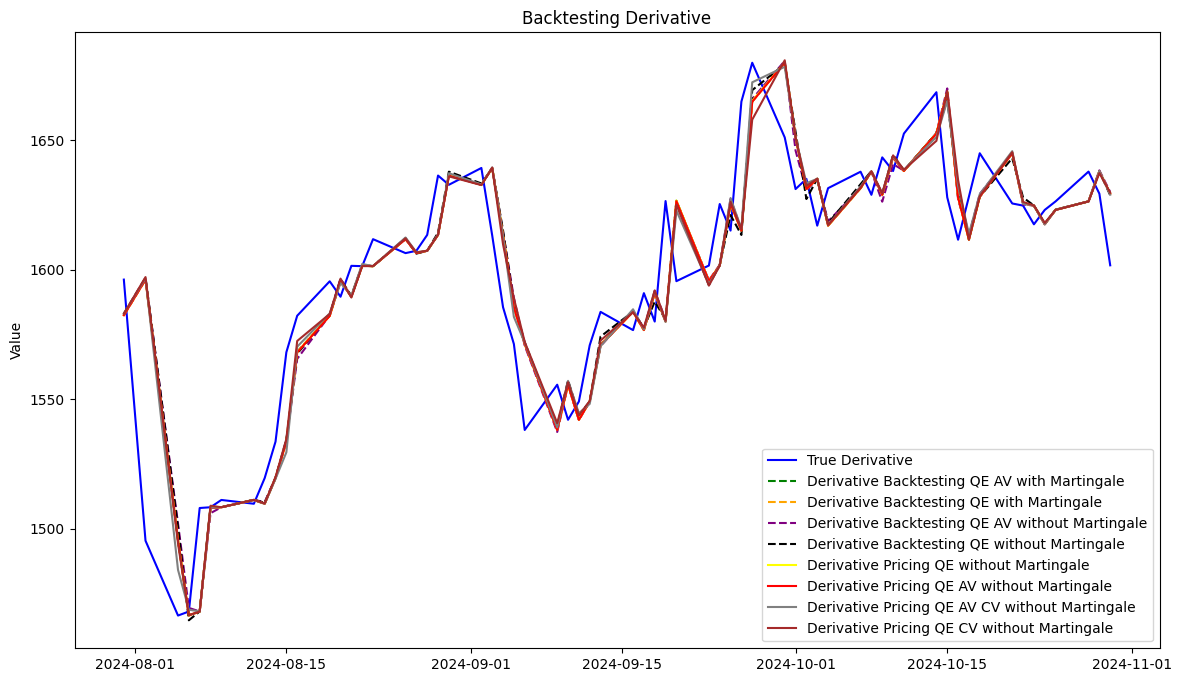

RMSE for Derivative Backtesting QE AV with Martingale: 22.49516798964286
RMSE for Derivative Backtesting QE with Martingale: 22.509990430990328
RMSE for Derivative Backtesting QE AV CV with Martingale: 22.688199511768648
RMSE for Derivative Backtesting QE CV with Martingale: 22.535295600514083
RMSE for Derivative Backtesting QE without Martingale: 22.511741252731127
RMSE for Derivative Backtesting QE AV without Martingale: 22.499452018282714
RMSE for Derivative Backtesting QE AV CV without Martingale: 22.187451250315615
RMSE for Derivative Backtesting QE CV without Martingale: 22.622708213811677


In [ ]:
plt.figure(figsize=(14,8))
plt.plot(price_backtest_true.index[:-1], true_derivative[:-1], label="True Derivative", color="blue", linestyle="-")
plt.plot(price_backtest_true.index[:-1], derivative_backtest_heston_qe_with_martingale[:-1], label="Derivative Backtesting QE AV with Martingale", color="green", linestyle="--")
plt.plot(price_backtest_true.index[:-1], derivative_backtest_heston_qe_av_with_martingale[:-1], label="Derivative Backtesting QE with Martingale", color="orange", linestyle="--")
plt.plot(price_backtest_true.index[:-1], derivative_backtest_heston_qe_av_cv_with_martingale[:-1], label="Derivative Backtesting QE AV without Martingale", color="purple", linestyle="--")
plt.plot(price_backtest_true.index[:-1], derivative_backtest_heston_qe_cv_with_martingale[:-1], label="Derivative Backtesting QE without Martingale", color="black", linestyle="--")
plt.plot(price_backtest_true.index[:-1], derivative_backtest_heston_qe_without_martingale[:-1], label="Derivative Pricing QE without Martingale", color="yellow", linestyle="-")
plt.plot(price_backtest_true.index[:-1], derivative_backtest_heston_qe_av_without_martingale[:-1], label="Derivative Pricing QE AV without Martingale", color="red", linestyle="-")
plt.plot(price_backtest_true.index[:-1], derivative_backtest_heston_qe_av_cv_without_martingale[:-1], label="Derivative Pricing QE AV CV without Martingale", color="grey", linestyle="-")
plt.plot(price_backtest_true.index[:-1], derivative_backtest_heston_qe_cv_without_martingale[:-1], label="Derivative Pricing QE CV without Martingale", color="brown", linestyle="-")


plt.ylabel("Value")
plt.title("Backtesting Derivative")
plt.legend()

plt.show()


mse_derivative_backtest_heston_qe_with_martingale = root_mean_squared_error(true_derivative[:-1], derivative_backtest_heston_qe_with_martingale[:-1])
mse_derivative_backtest_heston_qe_av_with_martingale = root_mean_squared_error(true_derivative[:-1], derivative_backtest_heston_qe_av_with_martingale[:-1])
mse_derivative_backtest_heston_qe_av_cv_with_martingale = root_mean_squared_error(true_derivative[:-1], derivative_backtest_heston_qe_av_cv_with_martingale[:-1])
mse_derivative_backtest_heston_qe_cv_with_martingale = root_mean_squared_error(true_derivative[:-1], derivative_backtest_heston_qe_cv_with_martingale[:-1])
mse_derivative_backtest_heston_qe_without_martingale = root_mean_squared_error(true_derivative[:-1], derivative_backtest_heston_qe_without_martingale[:-1])
mse_derivative_backtest_heston_qe_av_without_martingale = root_mean_squared_error(true_derivative[:-1], derivative_backtest_heston_qe_av_without_martingale[:-1])
mse_derivative_backtest_heston_qe_av_cv_without_martingale = root_mean_squared_error(true_derivative[:-1], derivative_backtest_heston_qe_av_cv_without_martingale[:-1])
mse_derivative_backtest_heston_qe_cv_without_martingale = root_mean_squared_error(true_derivative[:-1], derivative_backtest_heston_qe_cv_without_martingale[:-1])

print(f"RMSE for Derivative Backtesting QE AV with Martingale: {mse_derivative_backtest_heston_qe_av_with_martingale}")
print(f"RMSE for Derivative Backtesting QE with Martingale: {mse_derivative_backtest_heston_qe_with_martingale}")
print(f"RMSE for Derivative Backtesting QE AV CV with Martingale: {mse_derivative_backtest_heston_qe_av_cv_with_martingale}")
print(f"RMSE for Derivative Backtesting QE CV with Martingale: {mse_derivative_backtest_heston_qe_cv_with_martingale}")
print(f"RMSE for Derivative Backtesting QE without Martingale: {mse_derivative_backtest_heston_qe_without_martingale}")
print(f"RMSE for Derivative Backtesting QE AV without Martingale: {mse_derivative_backtest_heston_qe_av_without_martingale}")
print(f"RMSE for Derivative Backtesting QE AV CV without Martingale: {mse_derivative_backtest_heston_qe_av_cv_without_martingale}")
print(f"RMSE for Derivative Backtesting QE CV without Martingale: {mse_derivative_backtest_heston_qe_cv_without_martingale}")



# Estimating sensitivies: Delta and gamma

In [ ]:
h = es50_prices[n0-1]*0.001

S,Splush,Sminush = SimGBMexactperturbed(Nsim, es50_prices[n0-1],v,sigma,dt,T,h)
updated_array1 = np.array([np.concatenate((es50_prices, inner)) for inner in S])
updated_array2 = np.array([np.concatenate((es50_prices, inner)) for inner in Splush])
updated_array3 = np.array([np.concatenate((es50_prices, inner)) for inner in Sminush])

payoff_exact1 = []
for i in range(0,Nsim):
  payoff_exact1.append(payoff(1,updated_array1[i]))
Tminust= (business_days_between(date.today(),"2025-07-14"))/252
discount_factor = math.exp(-r*Tminust)
payoff_exact1_discounted = [payoff_exact1[i]*discount_factor for i in range(len(payoff_exact1))]
PV_Payoff1 = sum(payoff_exact1_discounted)/len(payoff_exact1_discounted)


payoff_exact2 = []
for i in range(0,Nsim):
  payoff_exact2.append(payoff(1,updated_array2[i]))
Tminust= (business_days_between(date.today(),"2025-07-14"))/252
discount_factor = math.exp(-r*Tminust)
payoff_exact2_discounted = [payoff_exact2[i]*discount_factor for i in range(len(payoff_exact2))]
PV_Payoff2 = sum(payoff_exact2_discounted)/len(payoff_exact2_discounted)


payoff_exact3 = []
for i in range(0,Nsim):
  payoff_exact3.append(payoff(1,updated_array3[i]))
Tminust= (business_days_between(date.today(),"2025-07-14"))/252
discount_factor = math.exp(-r*Tminust)
payoff_exact3_discounted = [payoff_exact3[i]*discount_factor for i in range(len(payoff_exact3))]
PV_Payoff3 = sum(payoff_exact3_discounted)/len(payoff_exact3_discounted)


delta = (PV_Payoff2-PV_Payoff3)/(2*h)
gamma = (PV_Payoff2-2*PV_Payoff1+PV_Payoff3)/h**2

print(delta)
print(gamma)


<ipython-input-68-6576040f778d>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  h = es50_prices[n0-1]*0.001
<ipython-input-68-6576040f778d>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S,Splush,Sminush = SimGBMexactperturbed(Nsim, es50_prices[n0-1],v,sigma,dt,T,h)


0.44301262400493474
1.1430334681290482e-13


In [ ]:
# Perturbation and Simulation
h = es50_prices[n0-1] * 0.001
S, Splush, Sminush = SimGBMexactperturbed(Nsim, es50_prices[n0-1], v, sigma, dt, T, h)

# Arrays with historical prices concatenated
updated_array1 = np.array([np.concatenate((es50_prices, inner)) for inner in S])
updated_array2 = np.array([np.concatenate((es50_prices, inner)) for inner in Splush])
updated_array3 = np.array([np.concatenate((es50_prices, inner)) for inner in Sminush])

# Time to maturity and discount factor
Tminust = business_days_between(date.today(), "2025-07-14") / 252
discount_factor = math.exp(-r * Tminust)

# Calculate discounted payoffs and present values
payoff_exact1 = [payoff(1, path) * discount_factor for path in updated_array1]
payoff_exact2 = [payoff(1, path) * discount_factor for path in updated_array2]
payoff_exact3 = [payoff(1, path) * discount_factor for path in updated_array3]

# Present values for each scenario
PV_Payoff1 = sum(payoff_exact1) / Nsim
PV_Payoff2 = sum(payoff_exact2) / Nsim
PV_Payoff3 = sum(payoff_exact3) / Nsim

# Calculating Delta and Gamma
delta = (PV_Payoff2 - PV_Payoff3) / (2 * h)
gamma = (PV_Payoff2 - 2 * PV_Payoff1 + PV_Payoff3) / h**2

# Display results
print("Delta:", delta)
print("Gamma:", gamma)

<ipython-input-66-9485fd7ff89e>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  h = es50_prices[n0-1] * 0.001
<ipython-input-66-9485fd7ff89e>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S, Splush, Sminush = SimGBMexactperturbed(Nsim, es50_prices[n0-1], v, sigma, dt, T, h)


Delta: 0.43504613622048066
Gamma: 1.0859627976943706e-06
